# **Court Dynamics Project**


## Step 0. Libraries

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from IPython.display import display
from sklearn.ensemble import IsolationForest



## Step 1: Merging Tables, Fixing the Draft Table


In this part of our project, we will reconstruct our data into 3 seperate csv files, plus the metadata table 'data_dictionary'. We will group them into the following groups: players, teams, & coaches.
This is because there are variables that connect all the other tables in the database file.

For players (players ;player_regular_season; player_regular_season_career; player_playoffs; player_playoffs_career; player_allstar, draft), the variable in common is **ilkid**.

For coaches (coaches_season; coaches_career), the variable in common is **coachid**.

For teams (teams, teams_season), the variable in common are **team** and **year** (we will use [team, year]).

Instead of having multiple collumns, the draft table appears to have one single text collumn whose name is all variable names, seperated by commas (draft_year,draft_round,selection,team,firstname,lastname,ilkid,draft_from,league).

### 1.1 Fixing the Draft Table

We will fix this table by separating all the variable names in the same collumn into different collumns.


In [2]:
db_path = "/content/basketball.db"
conn = sqlite3.connect(db_path)

# Loading the draft table
draft_raw = pd.read_sql_query("SELECT * FROM draft;", conn)

# Identify the column with all variables
combined_col = draft_raw.columns[0]

# ONLY IF the table still has 1 collumn (has not already been split), then split
if len(draft_raw.columns) == 1:

  draft_split = draft_raw[combined_col].str.split(",", expand=True)
  draft_split = draft_split.iloc[:, :9]

  draft_split.columns = [
      "draft_year",
      "draft_round",
      "selection",
      "team",
      "firstname",
      "lastname",
      "ilkid",
      "draft_from",
      "league",
  ]

else:
  # Already cleaned
  draft_split = draft_raw.copy()

# Remove the whitespace
for c in draft_split.columns:
    draft_split[c] = draft_split[c].astype(str).str.strip()

# Casting numeric fields safely
num_cols = ["draft_year", "draft_round", "selection"]

for col in num_cols:
    draft_split[col] = pd.to_numeric(draft_split[col], errors='coerce')

# Saving it as a draft table
draft_split.to_sql("draft", conn, if_exists="replace", index=False)

# Using only NBA draft (NOT ABA)
draft_clean = draft_split[draft_split['league'] == 'N'].copy()


print(draft_split.head(10))

conn.close()

   draft_year  draft_round  selection team firstname    lastname      ilkid  \
0      1971.0          9.0       11.0  PHI       Tom         Lee              
1      1975.0          2.0       11.0  HOU       Jim      Blanks              
2      1973.0          9.0        7.0  PHO     Sandy       Smith              
3      2002.0          1.0        1.0  HOU       Yao        Ming   MingYa01   
4      1956.0          0.0        0.0  SYR      Milt      Graham              
5      1976.0          4.0       14.0  WA1    Marion     Hillard              
6      1985.0          1.0       16.0  DAL      Bill  Wennington  WenniBi01   
7      1977.0          3.0        7.0  Ind      Stan      Mayhew              
8      1983.0         10.0       20.0  SAS     Lamar       Heard              
9      1983.0          1.0       12.0  NYK   Darrell      Walker  WalkeDa01   

        draft_from league  
0          Arizona      N  
1     Gardner-Webb      N  
2    Winston-Salem      N  
3  Shanghai Sharks

### 1.2 Merging the Tables into 3 Types: Players, Coaches, Teams

In this step we will merge the tables into 3 different groups, those being players (ilkid), teams ([team, year]), and coaches (coaches_id); as mentioned before.


#### 1.2.1 Merging the Players Table:
We will be using the players_regular_season as a base for this table, with one row per ilkid and year. The reason that we use players_regular_season is that it is the table that provides the most stable structure for players.

Then, we will attach all the other columns, so that the players_df will be a table that includes all the columns, with some columns duplicated across the seasons (this does not give us problems).

Lastly, we save this table into a .csv file, for easier access.

In [3]:
db_path = "/content/basketball.db"
conn = sqlite3.connect(db_path)

# Loading all the tables
players          = pd.read_sql("SELECT * FROM players;", conn)
reg_season       = pd.read_sql("SELECT * FROM player_regular_season;", conn)
reg_career       = pd.read_sql("SELECT * FROM player_regular_season_career;",
                               conn)
playoffs         = pd.read_sql("SELECT * FROM player_playoffs;", conn)
playoffs_career  = pd.read_sql("SELECT * FROM player_playoffs_career;", conn)
allstar          = pd.read_sql("SELECT * FROM player_allstar;", conn)
draft            = pd.read_sql("SELECT * FROM draft;", conn)

# Create a base (regular season)
players_df = reg_season.copy()

# Add the static player variables (height, name, last name etc.)
# Avoid duplicating variables that are already in regular reason.
player_bio_cols = ['ilkid', 'position', 'firstseason', 'lastseason',
                   'h_feet', 'h_inches', 'weight', 'college', 'birthdate'
]

players_df = players_df.merge(
    players[player_bio_cols],
    on='ilkid',
    how='left'
)

# Adding regular seasons career totals
career_reg_cols = [c for c in reg_career.columns if c not in ['firstname',
                                                              'lastname']]
players_df = players_df.merge(
    reg_career[career_reg_cols],
    on='ilkid',
    how='left',
    suffixes=('', '_career_reg')
)

# Add playoff season stats
playoffs_cols = [c for c in playoffs.columns if c not in ['firstname',
                                                          'lastname', 'team']]
players_df = players_df.merge(
    playoffs_cols := playoffs[playoffs_cols],
    on=['ilkid', 'year'],
    how='left',
    suffixes=('', '_playoffs_season')
)

# Add playoff career totals
playoffs_career_cols = [c for c in playoffs_career.columns if c not in
                        ['firstname', 'lastname']]
players_df = players_df.merge(
    playoffs_career[playoffs_career_cols],
    on='ilkid',
    how='left',
    suffixes=('', '_playoffs_career')
)

# Add all star stats
allstar_cols = [c for c in allstar.columns if c not in ['firstname',
                                                        'lastname', 'team']]
players_df = players_df.merge(
    allstar[allstar_cols],
    on=['ilkid', 'year'],
    how='left',
    suffixes=('', '_allstar')
)

# Add draft info
draft_cols = [
    'ilkid', 'draft_year', 'draft_round', 'selection',
    'team', 'draft_from', 'league'
]

# Renaming draft team to avoid colision, merging draft
draft_rename = draft_clean[draft_cols].rename(columns={'team': 'draft_team'})
players_df = players_df.merge(
    draft_rename,
    on='ilkid',
    how='left'
)

# Sort to make sure it is in order
players_df = players_df.sort_values(['ilkid', 'year']).reset_index(drop=True)

# Printing out all columns in players_df
print("Columns: ", players_df.columns.tolist(), "\n\n")

print(players_df.head())

# Exporting to .csv
players_df.to_csv("players.csv", index=False)

conn.close()


Columns:  ['ilkid', 'year', 'firstname', 'lastname', 'team', 'leag', 'gp', 'minutes', 'pts', 'oreb', 'dreb', 'reb', 'asts', 'stl', 'blk', 'turnover', 'pf', 'fga', 'fgm', 'fta', 'ftm', 'tpa', 'tpm', 'position', 'firstseason', 'lastseason', 'h_feet', 'h_inches', 'weight', 'college', 'birthdate', 'leag_career_reg', 'gp_career_reg', 'minutes_career_reg', 'pts_career_reg', 'oreb_career_reg', 'dreb_career_reg', 'reb_career_reg', 'asts_career_reg', 'stl_career_reg', 'blk_career_reg', 'turnover_career_reg', 'pf_career_reg', 'fga_career_reg', 'fgm_career_reg', 'fta_career_reg', 'ftm_career_reg', 'tpa_career_reg', 'tpm_career_reg', 'leag_playoffs_season', 'gp_playoffs_season', 'minutes_playoffs_season', 'pts_playoffs_season', 'dreb_playoffs_season', 'oreb_playoffs_season', 'reb_playoffs_season', 'asts_playoffs_season', 'stl_playoffs_season', 'blk_playoffs_season', 'turnover_playoffs_season', 'pf_playoffs_season', 'fga_playoffs_season', 'fgm_playoffs_season', 'fta_playoffs_season', 'ftm_playoffs_

#### 1.2.2 Merging the Teams Table:

We will be using team_season as the base for this table, with one row per team and year. The reason we use team_season is that it provides the most stable, complete season-by-season structure for teams.

Then, we will attach all the additional team-related columns from the teams table. This will give us a unified teams_df that includes both the season-level statistics and the static team information.

Lastly, we save this table into a .csv file, for easier access.

In [4]:
db_path = "/content/basketball.db"
conn = sqlite3.connect(db_path)

# Loading all the tables
teams       = pd.read_sql("SELECT * FROM teams;", conn)
team_season = pd.read_sql("SELECT * FROM team_season;", conn)

# Adding teams to teams_season
teams_df = team_season.merge(
    teams,
    on='team',
    how='left',
    suffixes=('', '_teaminfo')
)

# Sort the table
teams_df = teams_df.sort_values(['team', 'year']).reset_index(drop=True)

# Printing all the columns
print("Columns: ", teams_df.columns.tolist(), "\n\n")

print(teams_df.head())

# Exporting to .csv
teams_df.to_csv("teams.csv", index=False)

conn.close()

Columns:  ['team', 'year', 'leag', 'o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_3pm', 'o_3pa', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_oreb', 'd_dreb', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_3pm', 'd_3pa', 'd_pts', 'pace', 'won', 'lost', 'location', 'name', 'leag_teaminfo'] 


  team  year leag   o_fgm   o_fga   o_ftm   o_fta  o_oreb  o_dreb   o_reb  \
0  ANA  1967    A  3172.0  7606.0  2141.0  2916.0     0.0     0.0  4158.0   
1  AND  1949    N  1943.0  6254.0  1703.0  2343.0     0.0     0.0     0.0   
2  ATL  1968    N  3605.0  7844.0  1913.0  2785.0     NaN     0.0  4599.0   
3  ATL  1969    N  3817.0  7907.0     NaN  2669.0     0.0     0.0  4210.0   
4  ATL  1970    N  3614.0  7779.0     NaN     NaN     0.0     0.0  4472.0   

   ...  d_blk  d_3pm  d_3pa   d_pts  pace   won  lost  location  \
0  ...    0.0   99.0    0.0  9057.0   0.0  25.0  53.0   Anaheim   
1  ...    0.0    0.0    0.0  5350

#### 1.2.3 Merging the Coaches Table:
We will be using coaches_season as the base for this table, with one row per coachid and year. The reason we use coaches_season is that it provides the most consistent season-by-season structure for coaches, including their wins, losses, team assignments, and year-by-year performance.

Then, we will attach the additional columns from coaches_career, which contains each coach’s career totals.

Lastly, we save this table into a .csv file, for easier access.

In [5]:
db_path = "/content/basketball.db"
conn = sqlite3.connect(db_path)

# Loading all the tables
coaches_season = pd.read_sql("SELECT * FROM coaches_season;", conn)
coaches_career = pd.read_sql("SELECT * FROM coaches_career;", conn)

# Remove duplicates
coach_career_cols = [c for c in coaches_career.columns if c not in ['firstname', 'lastname']]


# Merge
coaches_df = coaches_season.merge(
    coaches_career[coach_career_cols],
    on='coachid',
    how='left',
    suffixes=('', '_career')
)

# Sort
coaches_df = coaches_df.sort_values(['coachid', 'year']).reset_index(drop=True)

# Print all columns

print("Columns: ", coaches_df.columns.tolist(), "\n\n")

print(coaches_df.head())

# Export to .csv
coaches_df.to_csv("coaches.csv", index=False)

conn.close()



Columns:  ['coachid', 'year', 'yr_order', 'firstname', 'lastname', 'season_win', 'season_loss', 'playoff_win', 'playoff_loss', 'team', 'season_win_career', 'season_loss_career', 'playoff_win_career', 'playoff_loss_career'] 


      coachid  year  yr_order firstname lastname  season_win  season_loss  \
0  ADELMRI01   1988       2.0      Rick  Adelman         NaN         21.0   
1  ADELMRI01   1989       1.0      Rick  Adelman        59.0         23.0   
2  ADELMRI01   1990       1.0      Rick  Adelman        63.0         19.0   
3  ADELMRI01   1991       1.0      Rick  Adelman        57.0         25.0   
4  ADELMRI01   1992       1.0      Rick  Adelman        51.0         31.0   

   playoff_win  playoff_loss team  season_win_career  season_loss_career  \
0          0.0           3.0  POR              658.0                 NaN   
1         12.0           9.0  POR              658.0                 NaN   
2          9.0           7.0  POR              658.0                 NaN   
3      

## Step 2: EDA
In the EDA phase of our project, we will explore the structure and quality of our new dataset tables. Our goal is to understand the data in order to be able to do the cleaning of it.

We will inspect the basic data structure, check for duplicates within the data, identify any missing values, examine distributions and descriptive statistics to find outliers or unusual patterns, verify time coverage and consistenct across players and coaches, and generate a few simple visualisations to understand the relationships between variables.

### 2.0 Loading the Data Files

In [6]:

players_df  = pd.read_csv("players.csv")
teams_df    = pd.read_csv("teams.csv")
coaches_df  = pd.read_csv("coaches.csv")

/tmp/ipython-input-270332299.py:1: DtypeWarning: Columns (67) have mixed types. Specify dtype option on import or set low_memory=False.
  players_df  = pd.read_csv("players.csv")


### 2.1 Learning the Basic Structures

In this part, firstly we will learn the number of rows, columns, sample rows and basic time ranges in each table.


In [7]:
# Inspecting players
print("Number of rows and columns in the players table: ", players_df.shape, "\n\n")
display(players_df.head())

# Inspecting teams
print("\n\nNumber of rows and columns in the teams table: ", teams_df.shape, "\n\n")
display(teams_df.head())

# Inspecting coaches
print("\n\nNumber of rows and columns in the coaches table: ", coaches_df.shape, "\n\n")
display(coaches_df.head())

Number of rows and columns in the players table:  (20618, 110) 




,ilkid,year,firstname,lastname,team,leag,gp,minutes,pts,oreb,...,fta_allstar,ftm_allstar,tpa_allstar,tpm_allstar,draft_year,draft_round,selection,draft_team,draft_from,league
0,ABDELAL01,1990,Alaa,Abdelnaby,POR,N,43.0,290.0,135.0,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABDELAL01,1991,Alaa,Abdelnaby,POR,N,71.0,934.0,432.0,81.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABDELAL01,1992,Alaa,Abdelnaby,MIL,N,12.0,159.0,64.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABDELAL01,1992,Alaa,Abdelnaby,TOT,N,75.0,1311.0,578.0,126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABDELAL01,1992,Alaa,Abdelnaby,BOS,N,NaN,1152.0,514.0,114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Number of rows and columns in the teams table:  (1455, 39) 




,team,year,leag,o_fgm,o_fga,o_ftm,o_fta,o_oreb,o_dreb,o_reb,...,d_blk,d_3pm,d_3pa,d_pts,pace,won,lost,location,name,leag_teaminfo
0,ANA,1967,A,3172.0,7606.0,2141.0,2916.0,0.0,0.0,4158.0,...,0.0,99.0,0.0,9057.0,0.0,25.0,53.0,Anaheim,Amigos,A
1,AND,1949,N,1943.0,6254.0,1703.0,2343.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5350.0,0.0,37.0,27.0,Anderson,Duffey Packers,N
2,ATL,1968,N,3605.0,7844.0,1913.0,2785.0,NaN,0.0,4599.0,...,0.0,0.0,0.0,8971.0,0.0,48.0,34.0,Atlanta,Hawks,N
3,ATL,1969,N,3817.0,7907.0,NaN,2669.0,0.0,0.0,4210.0,...,0.0,0.0,0.0,9610.0,0.0,48.0,34.0,Atlanta,Hawks,N
4,ATL,1970,N,3614.0,7779.0,NaN,NaN,0.0,0.0,4472.0,...,0.0,0.0,0.0,9495.0,0.0,36.0,46.0,Atlanta,Hawks,N




Number of rows and columns in the coaches table:  (1261, 14) 




,coachid,year,yr_order,firstname,lastname,season_win,season_loss,playoff_win,playoff_loss,team,season_win_career,season_loss_career,playoff_win_career,playoff_loss_career
0,ADELMRI01,1988,2.0,Rick,Adelman,NaN,21.0,0.0,3.0,POR,658.0,NaN,67.0,60.0
1,ADELMRI01,1989,1.0,Rick,Adelman,59.0,23.0,12.0,9.0,POR,658.0,NaN,67.0,60.0
2,ADELMRI01,1990,1.0,Rick,Adelman,63.0,19.0,9.0,7.0,POR,658.0,NaN,67.0,60.0
3,ADELMRI01,1991,1.0,Rick,Adelman,57.0,25.0,13.0,8.0,POR,658.0,NaN,67.0,60.0
4,ADELMRI01,1992,1.0,Rick,Adelman,51.0,31.0,1.0,3.0,POR,658.0,NaN,67.0,60.0


### 2.2 Checking for duplicates

After that, we will also check for duplicates in our dataframes, as this is a common issue after merging.

In [8]:
# Checking for duplicates in players
print("PLAYERS DATAFRAME DUPLICATES: ")

print("\nExact row duplicates in the players dataframe: ",
      players_df.duplicated().sum())

# Checking for rows with same player + same year
print("\nDuplicates of same player + same year: ",
      players_df.duplicated(subset=['ilkid', 'year']).sum())

# Because we see that rows with same [ilkid, year] are numerous, we now check
# rows with same [ilkid, year, team] (in case that it is only player transfers)

print("\nDuplicates of same player + year + team: ",
      players_df.duplicated(subset=['ilkid', 'year', 'team']).sum())


# Checking for duplicates in teams
print("\n\nTEAMS DATAFRAME DUPLICATES: ")

print("\nExact row duplicates in the teams dataframe: ",
      teams_df.duplicated().sum())

print("\nDuplicates of same team + year:",
      teams_df.duplicated(subset=['team', 'year']).sum())

# Checking for duplicates in coaches
print("\n\nCOACHES DATAFRAME DUPLICATES: ")

print("\nDuplicates of same coach + year: ",
      coaches_df.duplicated(subset=['coachid', 'year']).sum())

# Checking if it is only due to coach transfers
print("\nDuplicates of same coach + year + team: ",
      coaches_df.duplicated(subset=['coachid', 'year', 'team']).sum())


PLAYERS DATAFRAME DUPLICATES: 

Exact row duplicates in the players dataframe:  0

Duplicates of same player + same year:  4196

Duplicates of same player + year + team:  1461


TEAMS DATAFRAME DUPLICATES: 

Exact row duplicates in the teams dataframe:  19

Duplicates of same team + year: 254


COACHES DATAFRAME DUPLICATES: 

Duplicates of same coach + year:  3

Duplicates of same coach + year + team:  0


From this analysis, we can conclude that we have numerous duplicates that we will have to clean later on, when preprocessing and cleaning the dataset.

In the players dataframe, we have 0 exact duplicates, which is a good start. After seeing that we have a big number of duplicates of [ilkid, year], our assumption was that this number is due to player transfers to different teams during the season. Because of this, the next thing we checked was duplicates of [ilkid, year, team], and we can see that there is also a decent number of these. We will further analyise this issue, likely caused by merging, when we preprocess the data.

In the teams dataframe, we see 19 exact row duplicates, also likely caused by merging. We can also see 254 duplicates of [team, year]. This will also be further analyised in the preprocessing part of our project.

When it comes to the coaches dataframe, it is almost flawless. We have only 3 [coachid, year] duplicates, which we believe are caused simply by coach transfers to different teams. This belief is due to 0 duplicates of [coachid, year, team].

All in all, all of these duplicates will be analyized and cleaned in the preprocessing part of our project.

### 2.3 Missing values

In this step we will be checking for missing values in our dataset, so that we have a better idea of how we will process it later.

In [9]:
# We find the percentage of missing values in each player column
print("PLAYERS: ")
display(players_df.isna().mean().sort_values(ascending=False).head(65))

# We do the same for teams
print("\n\nTEAMS: ")
display(teams_df.isna().mean().sort_values(ascending=False).head(20))

# Same for coaches
print("\n\nCOACHES: ")
display(coaches_df.isna().mean().sort_values(ascending=False).head(20))



PLAYERS: 


,0
ftm_playoffs_season,1.000000
fga_playoffs_season,1.000000
stl_playoffs_season,1.000000
pf_playoffs_season,1.000000
turnover_playoffs_season,1.000000
...,...
draft_team,0.989524
turnover,0.117034
weight,0.111068
oreb_career_reg,0.110146




TEAMS: 


,0
o_blk,0.107216
o_oreb,0.105842
pace,0.105155
o_pf,0.104467
o_reb,0.104467
d_dreb,0.103780
d_asts,0.103780
d_stl,0.103093
d_3pm,0.103093
d_pf,0.103093




COACHES: 


,0
playoff_win_career,0.144330
playoff_loss_career,0.108644
playoff_win,0.099921
season_loss,0.099921
season_win,0.099921
yr_order,0.099921
playoff_loss,0.099921
season_loss_career,0.093577
season_win_career,0.082474
year,0.000000


In this analysis, we can see that the player dataframe has a lot of columns with no values, as well as a lot of columns missing more than 98% of their values. These results are normal, due to the fact that the columns either do not contain those variables in our version of the database, or contain those variables only for a very small subset of players. They were created during merging and will be removed during preprocessing.

The teams and coaches tables do not have large amounts of missing values, but we will dig deeper into this later.

### 2.4 Descriptive Statistics
In this step we want to see ranges, outliers, unrealistic values, zeros & NaNs, weird distributions and negative stats.

#### 2.4.1 Descriptive Statistics for Players

In [10]:
# Looking into player variables, by groups

print("PLAYERS: ")
# Basic stats
print("\n\nBASIC PLAYER STATS: ")
display(players_df[['minutes','pts','reb','asts','stl','blk','gp']].describe())

# Shooting statistics
print("\n\n SHOOTING STATISTICS FOR PLAYERS:")
display(players_df[['fga', 'fgm', 'fta', 'ftm', 'tpa', 'tpm']].describe())

# Career totals
print("\n\n PLAYERS CAREER TOTALS: ")
display(players_df.filter(like='_career').describe())

# Playoff stats
print("\n\n PLAYERS PLAYOFF STATISTICS: ")
display(players_df.filter(like='_playoffs_season').describe())

# All-Star Stats
print("\n\n PLAYERS ALL-STAR STATISTICS: ")
display(players_df.filter(like='_allstar').describe())

# Draft info
print("\n\n DRAFT STATISTICS: ")
display(players_df[['draft_year','draft_round','selection']].describe())



PLAYERS: 


BASIC PLAYER STATS: 


,minutes,pts,reb,asts,stl,blk,gp
count,18572.000000,18565.000000,18554.000000,18548.000000,18543.000000,18556.000000,18557.000000
mean,1233.888273,555.960194,242.024092,122.928941,32.030038,19.775437,52.864364
std,992.346550,521.852454,253.011880,138.152184,40.939812,37.089231,26.483837
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,292.000000,125.000000,47.000000,22.000000,0.000000,0.000000,30.000000
50%,1081.000000,409.000000,169.000000,77.000000,15.000000,5.000000,61.000000
75%,2060.000000,848.000000,350.000000,175.000000,52.000000,22.000000,77.000000
max,3882.000000,4029.000000,2149.000000,1134.000000,346.000000,456.000000,90.000000




 SHOOTING STATISTICS FOR PLAYERS:


,fga,fgm,fta,ftm,tpa,tpm
count,18545.000000,18557.000000,18540.000000,18545.000000,18556.000000,18570.000000
mean,474.176651,214.101848,155.860194,115.958156,30.227258,10.184168
std,422.067516,200.948008,156.800911,121.092914,72.173720,26.476048
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,119.000000,48.000000,34.000000,23.000000,0.000000,0.000000
50%,366.000000,157.000000,107.000000,77.000000,1.000000,0.000000
75%,730.000000,328.000000,230.000000,171.000000,17.000000,4.000000
max,3159.000000,1597.000000,1363.000000,840.000000,678.000000,267.000000




 PLAYERS CAREER TOTALS: 


,gp_career_reg,minutes_career_reg,pts_career_reg,oreb_career_reg,dreb_career_reg,reb_career_reg,asts_career_reg,stl_career_reg,blk_career_reg,turnover_career_reg,...,stl_playoffs_career,blk_playoffs_career,turnover_playoffs_career,pf_playoffs_career,fga_playoffs_career,fgm_playoffs_career,fta_playoffs_career,ftm_playoffs_career,tpa_playoffs_career,tpm_playoffs_career
count,18616.000000,18445.000000,18669.000000,18347.000000,18447.000000,18402.000000,18355.000000,18537.000000,18580.000000,18799.000000,...,2.000000,1.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.0,2.000000
mean,475.792866,11984.101057,5470.136537,499.672917,1215.381471,2348.599065,1224.447671,330.553596,206.361195,607.955796,...,44.500000,152.0,177.500000,129.000000,986.000000,514.500000,430.500000,308.500000,377.0,59.500000
std,338.704809,10879.055382,5713.188256,745.072107,1626.418494,2725.958139,1550.346679,412.805809,389.883527,738.247015,...,12.020815,NaN,106.773124,7.071068,873.983982,501.338708,292.035101,239.709199,NaN,84.145707
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,36.000000,152.0,102.000000,124.000000,368.000000,160.000000,224.000000,139.000000,377.0,0.000000
25%,167.000000,2370.000000,1015.000000,0.000000,24.000000,386.750000,175.000000,9.000000,3.000000,6.000000,...,40.250000,152.0,139.750000,126.500000,677.000000,337.250000,327.250000,223.750000,377.0,29.750000
50%,451.000000,9501.000000,3633.000000,190.000000,616.000000,1519.000000,701.000000,170.000000,57.000000,330.000000,...,44.500000,152.0,177.500000,129.000000,986.000000,514.500000,430.500000,308.500000,377.0,59.500000
75%,733.000000,18856.000000,8094.000000,685.500000,1766.000000,3333.000000,1717.500000,516.000000,221.500000,971.000000,...,48.750000,152.0,215.250000,131.500000,1295.000000,691.750000,533.750000,393.250000,377.0,89.250000
max,1611.000000,57446.000000,38387.000000,6731.000000,11511.000000,23924.000000,15806.000000,2514.000000,3830.000000,4524.000000,...,53.000000,152.0,253.000000,134.000000,1604.000000,869.000000,637.000000,478.000000,377.0,119.000000




 PLAYERS PLAYOFF STATISTICS: 


,leag_playoffs_season,gp_playoffs_season,minutes_playoffs_season,pts_playoffs_season,dreb_playoffs_season,oreb_playoffs_season,reb_playoffs_season,asts_playoffs_season,stl_playoffs_season,blk_playoffs_season,turnover_playoffs_season,pf_playoffs_season,fga_playoffs_season,fgm_playoffs_season,fta_playoffs_season,ftm_playoffs_season,tpa_playoffs_season,tpm_playoffs_season
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




 PLAYERS ALL-STAR STATISTICS: 


,leag_allstar,gp_allstar,minutes_allstar,pts_allstar,dreb_allstar,oreb_allstar,reb_allstar,asts_allstar,stl_allstar,blk_allstar,turnover_allstar,pf_allstar,fga_allstar,fgm_allstar,fta_allstar,ftm_allstar,tpa_allstar,tpm_allstar
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




 DRAFT STATISTICS: 


,draft_year,draft_round,selection
count,216.000000,216.000000,216.000000
mean,1993.532407,1.703704,11.564815
std,12.771657,1.913279,8.350767
min,1953.000000,1.000000,0.000000
25%,1990.000000,1.000000,3.000000
50%,2001.000000,1.000000,10.500000
75%,2001.000000,2.000000,18.000000
max,2001.000000,16.000000,28.000000


In the analysis above, the descriptive statistics tell us many things.

Firstly, let's look at the **basic, and shooting statistics**. We can see that the values for these are realistic and very well structured. They are what you would expect from NBA statistics of this type. The minimum values of 0 are expected, since there are players who do not get any playing time, thus they do not record any stats. The maximum values are also realistic, as top tier players play a lot and can achieve such statistics. In both basic and shooting statistics, the median values are below the means, suggesting a distribution skewed to the right.

The **career total** statistics show very wide ranges, this is due to different career lenghts of players. The max results are the greatests players in history, while the min are players who barely played. In the **playoff career** statistics, many career fields show only a few rows because only a few players had populated data after merging. This confirms what we saw in the missing values analysis: playoff and all-star data in our merged dataframe are very weak and will need careful handling or removal during preprocessing.

The **playoff** and **all-star** statistics in this merged tables are empty, showing that our merged dataset did not populate any values. We will deal with these during preprocessing.

**Draft statistics** contain valid values, but apply only to certain players, because older players do not have any draft information.



#### 2.4.2 Descriptive Statistics for Teams

In [11]:
# Looking into teams' variables
print("TEAMS: ")

# Basic team stats
print("\n\nBASIC TEAM STATISTICS: ")
display(teams_df[['won','lost','o_pts','d_pts','pace']].describe())

# Offensive statistics
print("\n\nOFFENSIVE STATISTICS: ")
offense_cols = [c for c in teams_df.columns if c.startswith('o_')] + ['pace']
display(teams_df[offense_cols].describe())

# Defensive statistics
print("\n\nDEFENSIVE TEAM STATISTICS:")
defense_cols = [c for c in teams_df.columns if c.startswith('d_')]
display(teams_df[defense_cols].describe())


TEAMS: 


BASIC TEAM STATISTICS: 


,won,lost,o_pts,d_pts,pace
count,1319.000000,1317.000000,1317.00000,1314.000000,1302.000000
mean,39.877180,39.684890,8310.28246,8177.828767,68.198788
std,12.414261,12.404168,1268.68022,1654.139191,46.915681
min,3.000000,8.000000,1087.00000,23.000000,0.000000
25%,31.000000,30.000000,7938.00000,7929.250000,0.000000
50%,41.000000,39.000000,8610.00000,8617.000000,94.228466
75%,48.000000,48.000000,9054.00000,9091.500000,103.084445
max,72.000000,73.000000,10371.00000,10723.000000,116.479910




OFFENSIVE STATISTICS: 


,o_fgm,o_fga,o_ftm,o_fta,o_oreb,o_dreb,o_reb,o_asts,o_pf,o_stl,o_to,o_blk,o_3pm,o_3pa,o_pts,pace
count,1310.000000,1309.000000,1309.000000,1310.000000,1301.000000,1311.000000,1303.000000,1318.000000,1303.000000,1314.000000,1314.000000,1299.000000,1322.000000,1312.00000,1317.00000,1302.000000
mean,3168.045802,6974.485867,1702.858671,2279.213740,737.393543,1601.339436,3631.899463,1822.345979,1897.283193,464.917047,918.978691,281.040801,159.226929,179.67378,8310.28246,68.198788
std,669.417280,1300.344812,352.325007,479.345763,533.309980,1150.797989,1052.965337,403.910656,329.034603,335.137048,660.428315,207.789509,180.462657,440.35268,1268.68022,46.915681
min,2.000000,4.000000,12.000000,23.000000,0.000000,0.000000,0.000000,18.000000,58.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1087.00000,0.000000
25%,2968.500000,6629.000000,1539.000000,2069.000000,0.000000,0.000000,3425.000000,1706.000000,1804.000000,0.000000,0.000000,0.000000,0.000000,0.00000,7938.00000,0.000000
50%,3378.000000,7189.000000,1722.000000,2301.000000,1010.000000,2325.000000,3635.000000,1900.000000,1953.000000,627.000000,1226.000000,355.000000,81.000000,0.00000,8610.00000,94.228466
75%,3575.750000,7704.000000,1926.000000,2550.000000,1163.000000,2477.000000,4006.500000,2070.750000,2082.000000,722.000000,1422.000000,438.000000,292.750000,0.00000,9054.00000,103.084445
max,4059.000000,9295.000000,2607.000000,3434.000000,1520.000000,3074.000000,6131.000000,2575.000000,2470.000000,1059.000000,2011.000000,716.000000,735.000000,2155.00000,10371.00000,116.479910




DEFENSIVE TEAM STATISTICS:


,d_fgm,d_fga,d_ftm,d_fta,d_oreb,d_dreb,d_reb,d_asts,d_pf,d_stl,d_to,d_blk,d_3pm,d_3pa,d_pts
count,1314.000000,1311.000000,1308.000000,1309.000000,1318.000000,1304.000000,1315.000000,1304.000000,1305.000000,1305.000000,1315.000000,1311.000000,1305.000000,1311.000000,1314.000000
mean,2617.786149,5625.279176,1360.717125,1781.464477,745.402883,1600.664877,2898.934601,1527.358129,1535.736398,456.789272,911.498859,282.276125,158.202299,176.710908,8177.828767
std,1382.295175,2956.028270,716.985387,966.708762,527.591541,1153.122387,1511.354253,804.448939,801.065583,332.705256,665.599400,204.353088,170.744559,422.771993,1654.139191
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000
25%,2710.500000,6270.500000,1329.000000,1730.000000,0.000000,0.000000,3211.000000,1460.250000,1650.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7929.250000
50%,3247.500000,6954.000000,1613.000000,2143.000000,1032.000000,2310.000000,3499.000000,1873.500000,1891.000000,634.000000,1211.000000,379.000000,94.000000,0.000000,8617.000000
75%,3531.000000,7418.000000,1825.250000,2410.000000,1154.750000,2485.250000,3774.000000,2052.000000,2030.000000,720.000000,1421.500000,440.000000,275.000000,0.000000,9091.500000
max,4265.000000,8889.000000,2377.000000,3273.000000,1525.000000,3107.000000,4875.000000,2537.000000,2453.000000,955.000000,1980.000000,654.000000,613.000000,1560.000000,10723.000000


Here, we can see descriptive statistics of basic, offensive and defensive team stats.

The **basic** team performances seem accurate. As before, the median values are slighly lower than the mean values, suggesting a slightly skewed to the right distributions. The zeros in pace  are likely from when this statistic was not recorded, in the earlier history of the NBA.

The **offensive** team statistics also seem mostly accurate. As before, the minimum values of 0 are expected for missing and unrecorded data through NBA history. The **3pm** and **3pa** have a very skewed distribution. We can assume that this is because in the early days of the NBA, 3 points did not exist, thus were always recorded as 0. Due to this, the median for these statistics is 0.

The **defensive** team statistics look good as well. These statistics reflect season level totals allowed by a team. Similar to the offense, many categories include zeros, also because of the same reason stated before.  

#### 2.4.3 Descriptive Statistics for Coaches

In [12]:
# Looking into coaches variables
print("COACHES: ")

print("\n\nCOACHES DESCRIPTIVE STATISTICS (ALL COLUMNS):")
display(coaches_df.describe(include='all'))

COACHES: 


COACHES DESCRIPTIVE STATISTICS (ALL COLUMNS):


,coachid,year,yr_order,firstname,lastname,season_win,season_loss,playoff_win,playoff_loss,team,season_win_career,season_loss_career,playoff_win_career,playoff_loss_career
count,1261,1261.000000,1135.000000,1261,1261,1135.000000,1135.000000,1135.000000,1135.000000,1261,1157.000000,1143.000000,1079.000000,1124.000000
unique,278,NaN,NaN,152,255,NaN,NaN,NaN,NaN,72,NaN,NaN,NaN,NaN
top,WILKELE01,NaN,NaN,Bill,Brown,NaN,NaN,NaN,NaN,NYK,NaN,NaN,NaN,NaN
freq,31,NaN,NaN,62,37,NaN,NaN,NaN,NaN,69,NaN,NaN,NaN,NaN
mean,NaN,1981.091990,1.926872,NaN,NaN,34.037885,34.146256,3.129515,3.185022,NaN,430.610199,383.902887,28.192771,28.671708
std,NaN,15.816741,6.863042,NaN,NaN,17.013206,14.734024,8.669005,8.295424,NaN,359.222352,298.179650,36.255124,27.885178
min,NaN,1946.000000,1.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
25%,NaN,1971.000000,1.000000,NaN,NaN,21.000000,24.000000,0.000000,0.000000,NaN,123.000000,153.000000,2.000000,5.000000
50%,NaN,1984.000000,1.000000,NaN,NaN,36.000000,34.000000,0.000000,2.000000,NaN,326.000000,294.000000,13.000000,21.000000
75%,NaN,1994.000000,1.000000,NaN,NaN,47.000000,43.000000,4.000000,4.000000,NaN,707.000000,545.000000,44.000000,49.000000


The **coaching descriptive statistics** show realistic data for coach wins, losses, playoff outcomes and career totals. Regular season statistics are also consistent with NBA expectations, showing typical results and right skewed distributions. Playoff statistics emphasize this skeweness even more, with a lot of coaches recording 0 playoff wins. Career statistics are spread widely, showing differences in lenghts of the coaches' careers.
Overall, the dataset is clear and behaves well.

### 2.5 Check Time Coverage
In this step, we check that each table spans the expected historical range of NBA seasons.


In [13]:

print("Time coverage for players: \nFrom: ", players_df['year'].min(), "\nTo: ",
      players_df['year'].max())
print("\n\nTime coverage for teams: \nFrom: ", teams_df['year'].min(), "\nTo: ",
      teams_df['year'].max())
print("\n\nTime coverage for coaches: \nFrom: ", coaches_df['year'].min(),"\nTo: ",
      coaches_df['year'].max())


Time coverage for players: 
From:  1946 
To:  2004


Time coverage for teams: 
From:  1946 
To:  2004


Time coverage for coaches: 
From:  1946 
To:  2003


In this **time coverage check** we check whether all 3 tables (players, teams, coaches) span within the same years. **Players** and **teams** span from 1946 to 2004. On the other hand, the last year for the coaches is **2003**. The one year difference is not large, and it is expected due to variation in data avaliability.

### 2.6 Visualising Distributions
In this step, we will be creating graphs that will help us better understand the data, see outliers, and observe how different variables are distributed across players, teams and coaches. Using these visualisations we will see skewenes, extreme values, and patterns that are not obvious from the tables alone. These insights will guide us on how to preprocess the data later.

#### 2.6.1 Visualising Distributions for Players

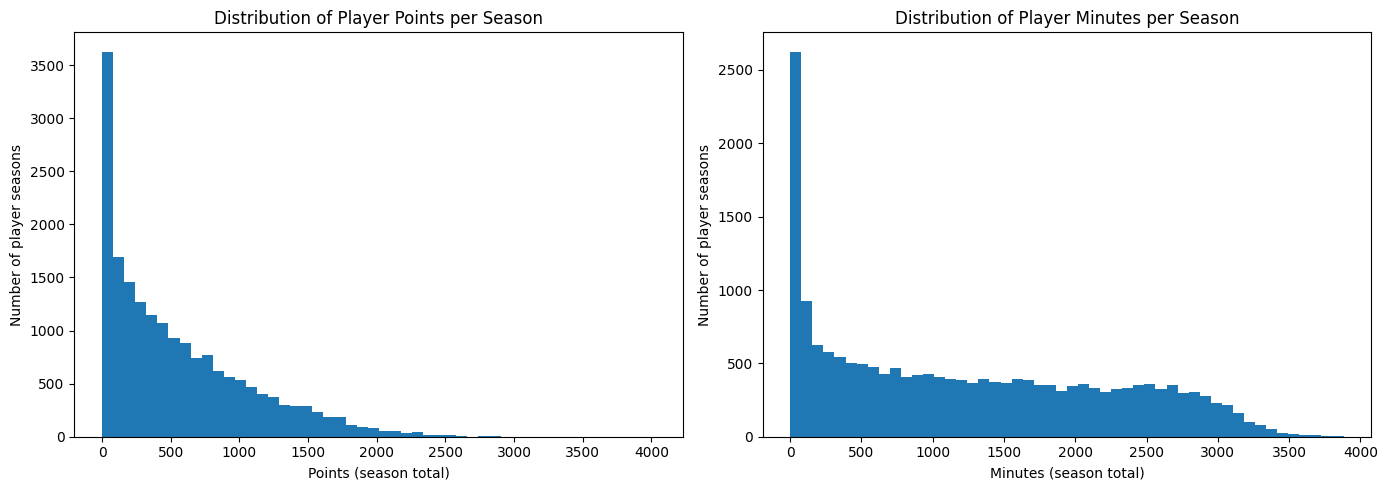

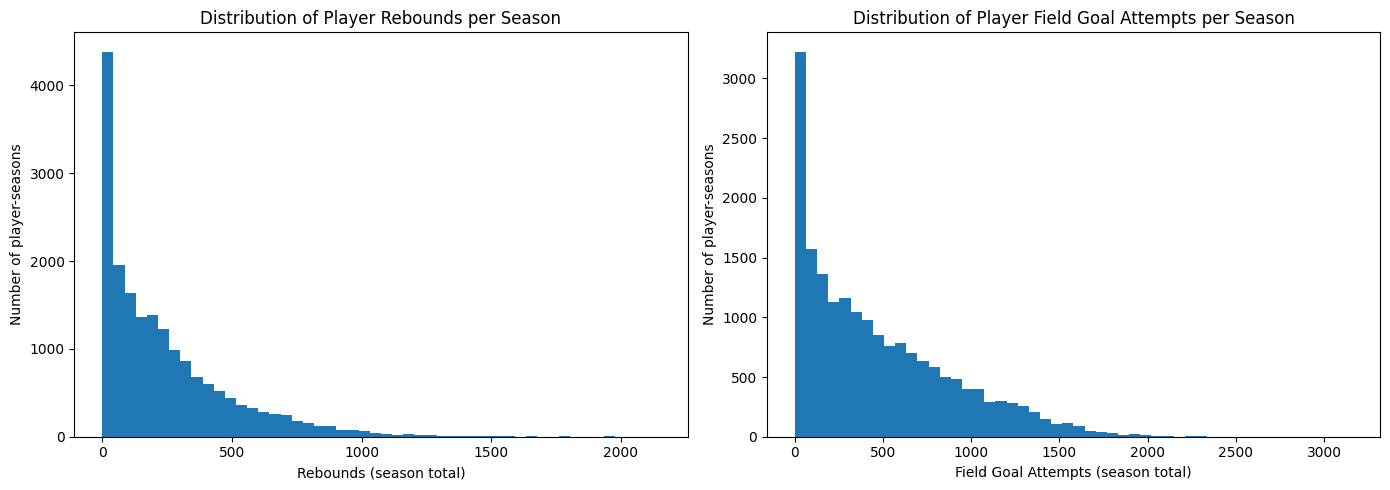

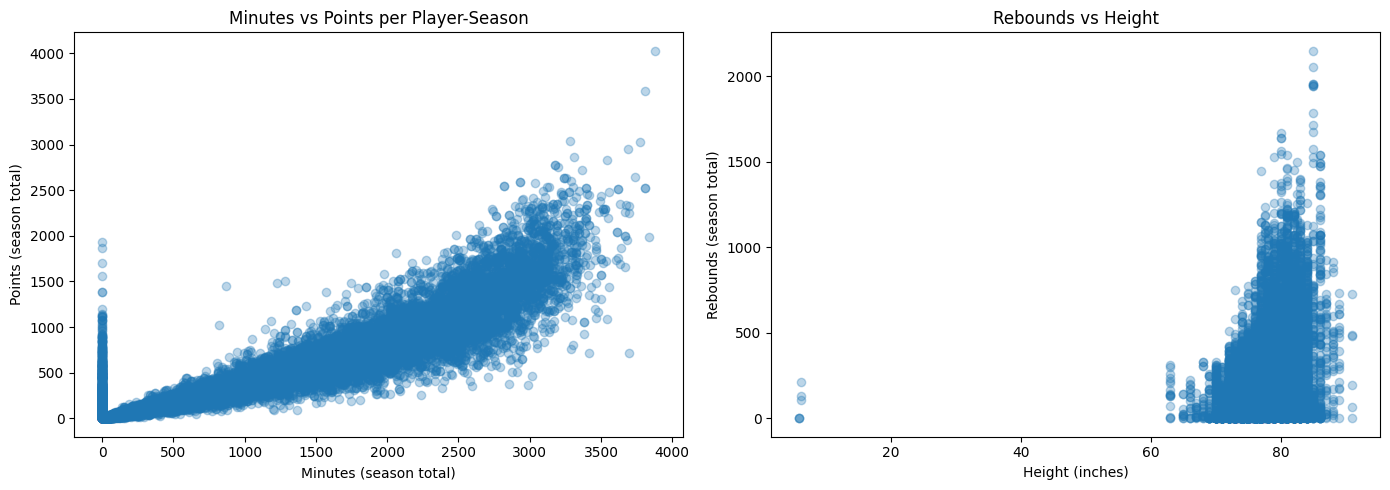

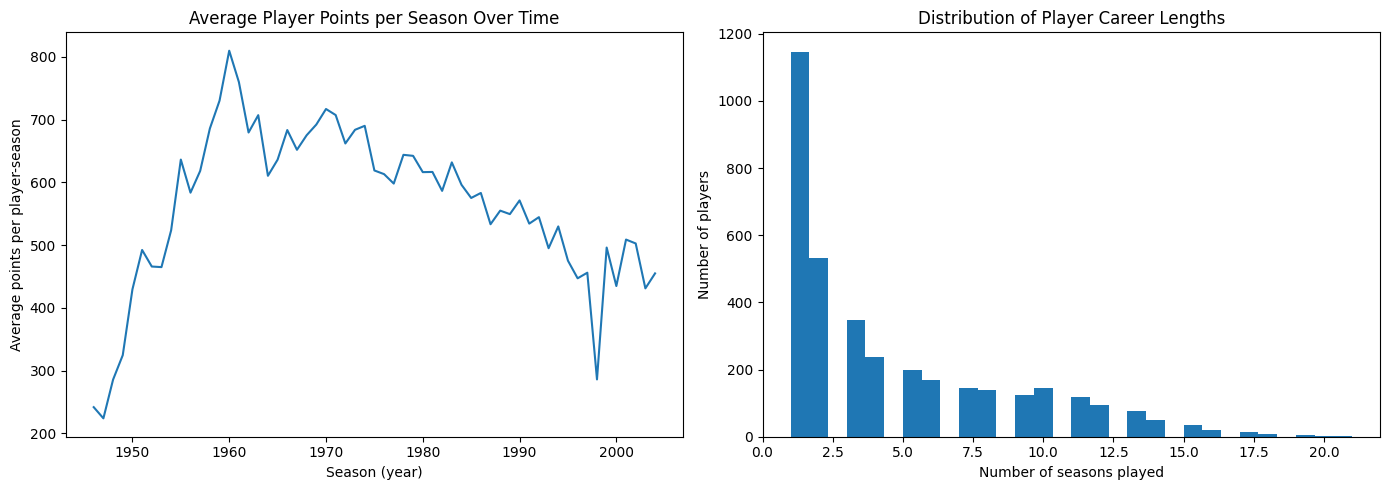

In [14]:
# 1. HISTOGRAM: Players Points per Season
# Showing the distribution of scoring + outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(players_df['pts'], bins=50)
axes[0].set_xlabel('Points (season total)')
axes[0].set_ylabel('Number of player seasons')
axes[0].set_title('Distribution of Player Points per Season')

# 2. HISTOGRAM: Minutes Played per Season
# Checks the distribution of player usage
# Helps see bench players vs. starters

axes[1].hist(players_df['minutes'], bins=50)
axes[1].set_xlabel('Minutes (season total)')
axes[1].set_ylabel('Number of player seasons')
axes[1].set_title('Distribution of Player Minutes per Season')

plt.tight_layout()
plt.show()


# 3. HISTOGRAM: Rebounds per Season
# Helps us see how rebounding spreads across players
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(players_df['reb'], bins=50)
axes[0].set_xlabel('Rebounds (season total)')
axes[0].set_ylabel('Number of player-seasons')
axes[0].set_title('Distribution of Player Rebounds per Season')

# 4. HISTOGRAM: Field Goal Attempts (FGA) per Season
# Helps us see players who have big roles in scoring

axes[1].hist(players_df['fga'], bins=50)
axes[1].set_xlabel('Field Goal Attempts (season total)')
axes[1].set_ylabel('Number of player-seasons')
axes[1].set_title('Distribution of Player Field Goal Attempts per Season')

plt.tight_layout()
plt.show()


# 5. SCATTERPLOT: Minutes vs. Points
# Helps us observe the relationship between playing time and scoring
# Helps us see how much minutes on the court affect point scored

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(players_df['minutes'], players_df['pts'], alpha=0.3)
axes[0].set_xlabel('Minutes (season total)')
axes[0].set_ylabel('Points (season total)')
axes[0].set_title('Minutes vs Points per Player-Season')

# 6. SCATTERPLOT: Rebounds vs Height
# Helps see the relationship between height and rebounds

height_in = players_df['h_feet'] * 12 + players_df['h_inches']

axes[1].scatter(height_in, players_df['reb'], alpha=0.3)
axes[1].set_xlabel('Height (inches)')
axes[1].set_ylabel('Rebounds (season total)')
axes[1].set_title('Rebounds vs Height')

plt.tight_layout()
plt.show()


# 7. LINE PLOT: Average Player Points per Season Over Time
# This ilustrates how scoring has evolved over the eras

avg_pts_by_year = players_df.groupby('year')['pts'].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(avg_pts_by_year['year'], avg_pts_by_year['pts'])
axes[0].set_xlabel('Season (year)')
axes[0].set_ylabel('Average points per player-season')
axes[0].set_title('Average Player Points per Season Over Time')

# 8. HISTOGRAM: Player Career Length / Seasons Played
# Helps us see how long players stay in the league

career_lengths = players_df.groupby('ilkid')['year'].nunique()


axes[1].hist(career_lengths, bins=30)
axes[1].set_xlabel('Number of seasons played')
axes[1].set_ylabel('Number of players')
axes[1].set_title('Distribution of Player Career Lengths')

plt.tight_layout()
plt.show()

We can conclude many things from these visualisations.

1. Looking at the first graph, **Player Points per Season**, we notice a very steep right skew. The more points we get to, the smaller the group of players is, which tells us that NBA points are heavily concentrated withing starters and other high-usage players.

2. **Players Minutes per Season** reveals that most players recieve very limited court time, with a rapid drop after the lowest minute totals. This proves that NBA playtime for deeper bench players is minimal, and almost all of it is given to key players. We can see a similarity between this and the last graph, confirming that playing time is a major factor in point production.

3. The **Distribution of Player Rebounds per Season** is also right skewed, with only a small group having high totals. This reflects differences in basketball position, with centers dominating rebounds, and guards contributing a lot less.

4. The **Distribution of Player Field Goal Attempts per Season** also tells us that offense is ran mostly by few star players, with role and bench players taking only few shots.

5. The **Minutes vs. Points per Season** scatterplot proves that there is a strong relationship between minutes player and points scored in a season, which we have already assumed. It shows that the time spend on court is the primary factor in scoring a lot of points. Most players cluster on low minutes and low points, while higher playtime players almost always score high amounts of points.

6. **Rebounds vs. Height** scatterplot proves that taller players do in fact get more rebounds. The height with the highest density of rebounds is around 78 inches, that being 198cm of height. There are a few outliers, those being short players with high reboundiing, or even tall players with low rebounding.

7. **Average Player Points per Season Over Time** plots how scoring has evolved throughout NBA history. It had a sharp rise early on, peaked between 1960-1980, and later fell off. This helps us see that context is very important when comparing players from different eras.

8. **Distribution of Player Career Lengths** shows us that a lot of players have really short careers, while a small amount stay in the NBA for 10 or more years. It shows us that it is difficult to have a long career in the NBA, and that only great players manage to do so.

#### 2.6.2 Visualising Distributions for Teams

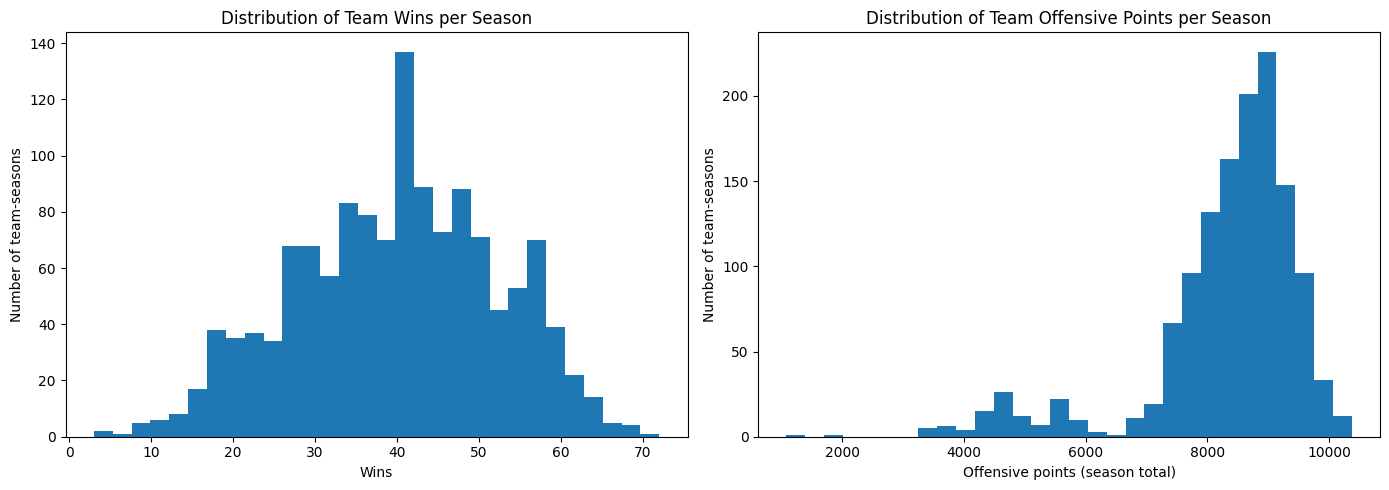

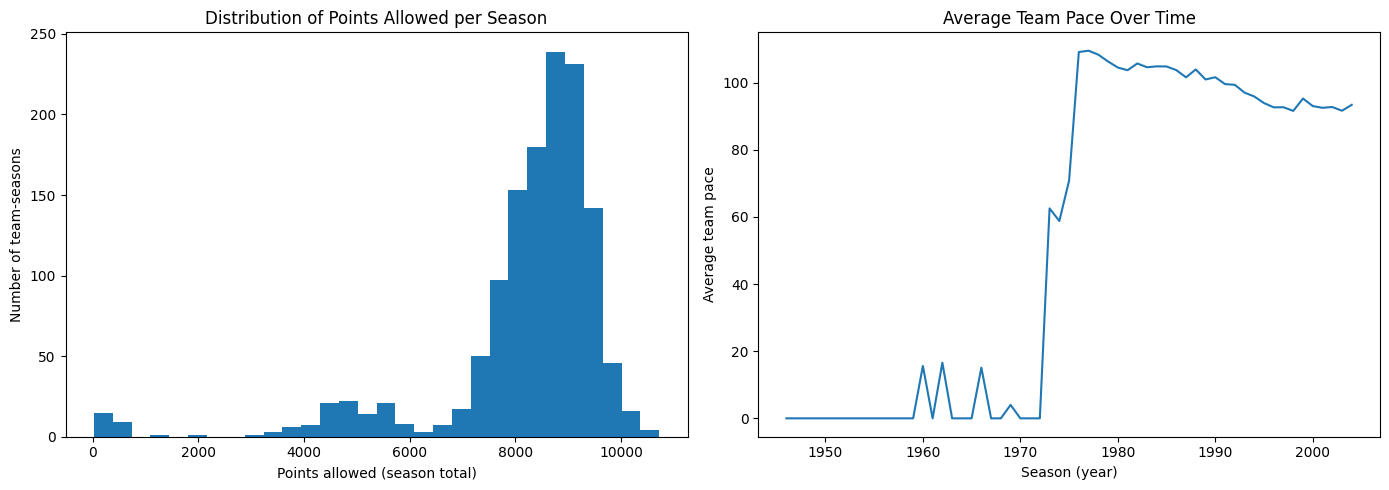

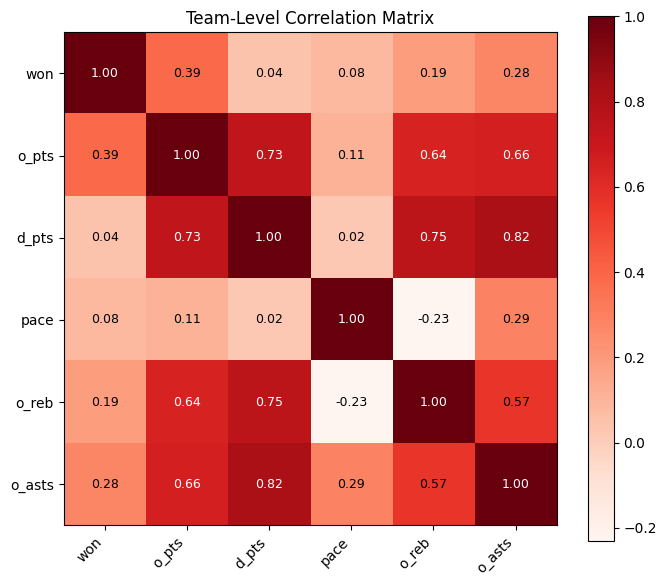

In [15]:
# 1. HISTOGRAM: Teams Wins per Season
# Shows us how team wins are distributed across all seasons

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(teams_df['won'], bins=30)
axes[0].set_xlabel('Wins')
axes[0].set_ylabel('Number of team-seasons')
axes[0].set_title('Distribution of Team Wins per Season')

# 2. HISTOGRAM: Team Points Scored
# Shows us the distribution of total points scored by teams in a season

axes[1].hist(teams_df['o_pts'], bins=30)
axes[1].set_xlabel('Offensive points (season total)')
axes[1].set_ylabel('Number of team-seasons')
axes[1].set_title('Distribution of Team Offensive Points per Season')

plt.tight_layout()
plt.show()

# 3. HISTOGRAM: Team Points Allowed
# Shows us the how many points teams allow over a season

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(teams_df['d_pts'], bins=30)
axes[0].set_xlabel('Points allowed (season total)')
axes[0].set_ylabel('Number of team-seasons')
axes[0].set_title('Distribution of Points Allowed per Season')

# 4. LINE PLOT: Pace over Time
# Shows us how the average team pace changes over time
# Pace = number of possesions per 48mins

pace_by_year = teams_df.groupby('year')['pace'].mean().reset_index()

axes[1].plot(pace_by_year['year'], pace_by_year['pace'])
axes[1].set_xlabel('Season (year)')
axes[1].set_ylabel('Average team pace')
axes[1].set_title('Average Team Pace Over Time')

plt.tight_layout()
plt.show()

# 5. HEATMAP: Team - Level Correlation Matrix
# Shows us the pairs between team performance and other variables

corr_cols = ['won', 'o_pts', 'd_pts', 'pace', 'o_reb', 'o_asts']
corr_matrix = teams_df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(corr_matrix.values, cmap = "Reds")

ax.set_xticks(range(len(corr_cols)))
ax.set_xticklabels(corr_cols, rotation=45, ha='right')
ax.set_yticks(range(len(corr_cols)))
ax.set_yticklabels(corr_cols)

ax.set_title('Team-Level Correlation Matrix')

# Adding values to heat map squares for better understanding
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        value = corr_matrix.values[i, j]
        ax.text(
            j, i,
            f"{value:.2f}",         # format to 2 decimal places
            ha='center', va='center',
            color='black' if abs(value) < 0.6 else 'white',  # contrast for readability
            fontsize=9
        )

plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


Now let us analyize the visualisations for the coaches dataframe.

In **The Distribution of Teams per Season** histogram we can see a bell curve, with the center of it being around 40-45 wins. This is to be expected, given that the NBA regular seasons has 82 games. We can see that most teams finish within a moderate range, with very low and very high winning teams are extremes.

When it comes to **The Distribution of Team Offensive Points per Season**, we can see that it is strongly right skewed. We can assume that the higher scoring seasons are from more recent years, with the 3 pointer in the game and a faster paced game.

The **Distribution of of Points Allowed** per season also shows a strong right skew. It is very similar to the previous graph, as to be expected.

The **Average Team Pace over Time** line plot reveals a dramatic shift a bit after 1970. The pacing was slow and inconsistent in the early stages of the NBA, those being the 1950s and 1960s. There is a major spike in the 1970s, with a decline throughout the 1990s and 2000s. After this, the pace over time stabilized in the modern era.

**The Heatmap** reveals many important relationships among the metrics. Firstly, we see a positive correlations of wins and offensive points (0.39), indicating that scoring is associated with winning, but not too closely. Points allowed have a strong relationship with offensive rebounds (0.75) and assists (0.82). Offensive points also have strong correlations with defensive points (0.73), offensive rebounds (0.64) and assists (0.66).

#### 2.6.3 Visualising Distributions of Coaches

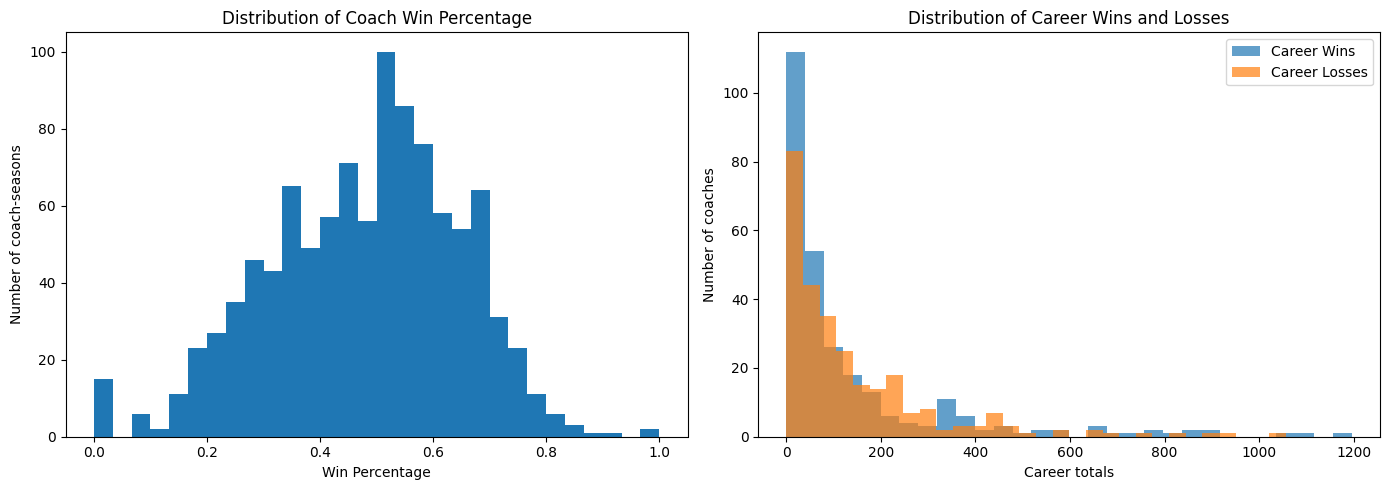

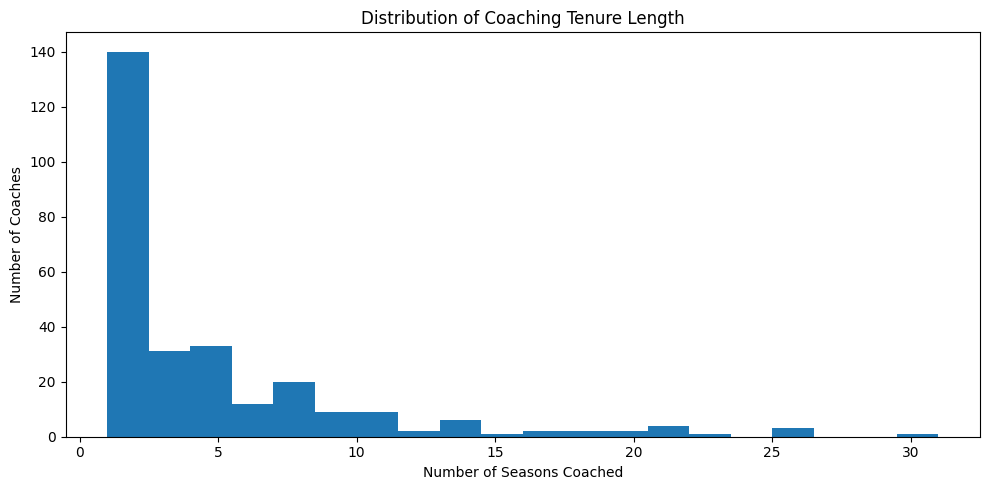

In [16]:
# 1. HISTOGRAM: Coach Win Percentage
# Helps us see how coaching success rates are distributed across seasons
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
win_pct = coaches_df['season_win'] / (coaches_df['season_win'] + coaches_df['season_loss'])

axes[0].hist(win_pct.dropna(), bins=30)
axes[0].set_xlabel('Win Percentage')
axes[0].set_ylabel('Number of coach-seasons')
axes[0].set_title('Distribution of Coach Win Percentage')


# 2. HISTOGRAM: Career Wins / Career Losses
# Helps us visualise how total regular seasons success is across careers
career_wins = coaches_df.groupby('coachid')['season_win'].sum()
career_losses = coaches_df.groupby('coachid')['season_loss'].sum()

axes[1].hist(career_wins, bins=30, alpha=0.7, label='Career Wins')
axes[1].hist(career_losses, bins=30, alpha=0.7, label='Career Losses')
axes[1].set_xlabel('Career totals')
axes[1].set_ylabel('Number of coaches')
axes[1].set_title('Distribution of Career Wins and Losses')
axes[1].legend()

plt.tight_layout()
plt.show()

# 3. BAR PLOT: Coaches by Number of Seasons Coached
# Helps us see how long coaches usually remain
seasons_per_coach = coaches_df.groupby('coachid')['year'].nunique()

plt.figure(figsize=(10, 5))
plt.hist(seasons_per_coach, bins=20)
plt.xlabel('Number of Seasons Coached')
plt.ylabel('Number of Coaches')
plt.title('Distribution of Coaching Tenure Length')
plt.tight_layout()
plt.show()

Now let's analyize the coach dataframe visualisations.

The **Distribution of Coach Win Percentage** shows a widely spread histogram. Most of the coaches cluster around the middle of the graph, showing us that maintaining a very high win percentage tends to be very difficult and rare. On the other hand, there is a left-tail showing us that there are coaches who proved to be unsucessful, with very low win percentages.

The **Distribution of Career Wins and Losses** reveals a steep right skew for both of the metrics, showing us that most of the coaches do not stay in the league long enough to record many wins/losses. We can conclude that getting to a lot of wins has a much more to do with how long a coach stays in the league, rather than their win/loss ratio.

Lastly, **Distribution of Number of Seasons Coached** also shows a right skew. Most of the coaches stay in the league for only 1-3 seasons, while only a few manage to have careers over a decade long.

### 2.7 Player Correlation Matrix
In this step we will create a player correlation matrix, to see relationships that will help us with future clustering and player types.

In [17]:
# Creating a Correlation Matrix
player_corr_cols = ['pts', 'reb', 'asts', 'stl', 'blk', 'minutes']
player_corr = players_df[player_corr_cols].corr()

player_corr

,pts,reb,asts,stl,blk,minutes
pts,1.000000,0.733022,0.693373,0.544190,0.365420,0.906118
reb,0.733022,1.000000,0.382285,0.323069,0.516031,0.791221
asts,0.693373,0.382285,1.000000,0.635099,0.121951,0.735727
stl,0.544190,0.323069,0.635099,1.000000,0.410290,0.612222
blk,0.365420,0.516031,0.121951,0.410290,1.000000,0.417170
minutes,0.906118,0.791221,0.735727,0.612222,0.417170,1.000000


In the correlation matrix, we can see that minutes played have the strongest correlation with all the stats, confirming that statistics are mostly driven by playing time. Points have a strong relationship with rebounds (0.73) and assists (0.69). Steals and assists also have a strong correlation (0.63), showing that guards/playmakers usually perform well in both of these categories. On the other hand, blocks having a 0.52 correlation with rebounds shows us that players who rebound well also perform well in blocks, indicating that these are tall players, usually at the center position. Overall, we can use this matrix to see which statistics rise together and with regards to this create player types.


### 2.8 Player, Team & Coach Counts
Here we will see how many players, teams and coaches we have.

In [18]:
# Number of unique players
print("The number of unique players is:", players_df['ilkid'].nunique())

# Number of unique teams
print("The number of unique teams is :", teams_df['team'].nunique())

# Number of unique coaches
print("The number of unique coaches is:", coaches_df['coachid'].nunique())

The number of unique players is: 3611
The number of unique teams is : 95
The number of unique coaches is: 278


These counts show how many distinct players, teams, and coaches appear in our merged dataset, giving us a clear idea of the dataset’s overall scale and historical coverage.

In [19]:
players_df.head()

,ilkid,year,firstname,lastname,team,leag,gp,minutes,pts,oreb,...,fta_allstar,ftm_allstar,tpa_allstar,tpm_allstar,draft_year,draft_round,selection,draft_team,draft_from,league
0,ABDELAL01,1990,Alaa,Abdelnaby,POR,N,43.0,290.0,135.0,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABDELAL01,1991,Alaa,Abdelnaby,POR,N,71.0,934.0,432.0,81.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABDELAL01,1992,Alaa,Abdelnaby,MIL,N,12.0,159.0,64.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABDELAL01,1992,Alaa,Abdelnaby,TOT,N,75.0,1311.0,578.0,126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABDELAL01,1992,Alaa,Abdelnaby,BOS,N,NaN,1152.0,514.0,114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 3: Understanding the Problem and Determining the Approach

### 3.1 Project Motivation
Player development and role dynamics are nonlinear and context-dependent. Traditional basketball analytics focus on single-season snapshots or box-score aggregates, which overlook the subtle ways players’ roles evolve—either through coaching decisions, roster changes, or natural skill progression.
The Court Dynamics project aims to build a data-driven framework that captures these temporal dynamics and enables coaches, analysts, and scouts to understand how players change, not just how they perform.

### 3.2 Core Analytical Problem
**How can we model, track, and interpret a player’s evolving role and performance trajectory over time using machine-learning methods?**

This involves identifying meaningful structure data and detecting patterns such as:

*   Emerging role changes (e.g., scorer → facilitator, wing → stretch big)
*   Developmental growth or stagnation
*   Anomalies caused by injuries, roster changes, or tactical shifts
*   Similarity groupings among players with shared trajectories

### 3.3 Scope of the Analysis
The project uses the already merged "basketball.db" as the primary data backbone. These contain player-level and game-level metrics necessary for:
- Season-to-season statistical profiles
- Time-series patterns in performance metrics
- Contextual variables (team, minutes, usage, etc.)

The analysis will focus on:
- Identifying latent roles or archetypes
- Tracking role transitions
- Modeling player development curves
- Detecting performance anomalies

This is not purely predictive; it is interpretability-driven and geared toward understanding rather than predicting.

### 3.4 Project Roadmap

As the project transitions into the modeling and technical implementation phase, the analysis will follow a structured pipeline designed to identify player roles and examine how these roles evolve over time. Because the database already provides merged tables, our workflow can begin with data preprocessing, followed by a series of analytical steps that build toward interpretable and context-aware insights.

The first stage involves preparing the dataset for modeling. Although the underlying tables are already integrated, preprocessing remains essential to ensure analytical reliability. This includes cleaning the data, addressing missing values, normalizing variables with differing scales, selecting informative features, and structuring the data into consistent formats. Effective preprocessing establishes the foundation on which the subsequent machine-learning methods can operate.

Following preprocessing, we will implement dimensionality reduction techniques to address the high dimensionality inherent in basketball statistics. Players typically accumulate a broad array of numerical features, many of which are redundant or weakly informative. Dimensionality reduction methods will be used to compress these features into a lower-dimensional embedding that preserves the essential structure of player performance. This transformation simplifies the dataset, enhances interpretability, and provides a stable analytical space in which similarity relationships between players become more meaningful.

With this embedded representation established, the next step is role discovery through clustering. Rather than imposing predefined role categories, clustering allows the data to reveal natural groupings of players based on their statistical profiles. The implementation will involve evaluating multiple clustering algorithms, optimizing their parameters, and validating the coherence and basketball relevance of the resulting clusters. These clusters form the basis for defining empirical player roles.

Finally, we will conduct temporal modeling to analyze how player roles change across seasons. By tracking each player’s movement within the embedded space and examining transitions between clusters, we can quantify developmental trajectories, identify role shifts, and detect atypical or significant changes. This temporal component directly supports the project’s overarching goal of understanding the dynamics of player evolution.

Collectively, these stages—preprocessing, dimensionality reduction, clustering, and temporal analysis—constitute the core of the implementation pipeline. They provide a rigorous and interpretable framework through which the project can analyze player development and role dynamics in a systematic and data-driven manner.

### 3.5 Rationale for Using Clustering Rather Than Classification or Regression

Clustering was selected as the primary modeling approach for role identification because it aligns most closely with the project’s objectives and the structure of the available data. Unlike classification or regression models, clustering provides a flexible, data-driven way to uncover underlying patterns without requiring predefined labels or outcome variables. Several factors make clustering the most appropriate methodological choice for this stage of the analysis.

First, the project aims to discover player roles rather than predict them. Classification requires labeled categories (e.g., predefined “scorer,” “playmaker,” “defensive anchor”) to train the model, but such labels do not exist in the database and are inherently subjective. Using classification would force us to impose an external, potentially biased taxonomy of roles. Clustering, in contrast, identifies natural groupings that emerge from players’ statistical profiles, allowing roles to be defined empirically rather than prescriptively.

Second, regression methods are designed to estimate relationships between features and a specific target variable, such as predicting points, efficiency, or win shares. However, the goal of this project is not to forecast a single metric but to understand multidimensional patterns of player behavior. Regression cannot capture this structural variation or reveal the latent dimensions that differentiate playing styles. Clustering, on the other hand, is well suited for analyzing high-dimensional data and detecting distinct player archetypes.

Third, clustering supports the project’s emphasis on interpretability and temporal analysis. By grouping similar player-seasons within a low-dimensional embedding, clustering provides discrete, interpretable role categories that can be tracked over time. This makes it possible to study transitions between roles, examine developmental trajectories, and detect anomalous career shifts. Classification would restrict players to predefined labels, and regression would not provide categorical structure at all, making both approaches far less effective for temporal role modeling.

Finally, clustering integrates naturally with the dimensionality reduction step of the pipeline. Once players are embedded into a lower-dimensional space, clustering becomes a powerful tool for revealing the underlying organization of that space. This synergy between embedding and clustering allows the project to represent the league’s player ecosystem in a way that is both analytically coherent and visually interpretable.

For these reasons, clustering offers the most conceptually appropriate and methodologically flexible approach for identifying player roles and supporting the broader objectives of modeling player evolution within the Court Dynamics framework.

## Step 4: Data Preprocessing

### 4.1 Duplicate Handling
As the first step to achieve a robust data, we start by handling the duplicates across all datasets


#### 4.1.1 Players Table
As we noted in our earlier analysis, the presence of both (player, year) and (player, year, team) duplicates strongly indicates a mixture of:
genuine multi-team seasons (authentic NBA behavior), and
merge artifacts created when multiple statistical sources were combined into a single table.

Because the goal of our project is to build a clean player-season dataset for temporal modeling and role analysis, duplicates of this type must be resolved carefully. Removing them blindly would destroy genuine information, while leaving them in place would distort the modeling process (especially dimensionality reduction, where duplicate rows artificially weight certain players).

Therefore, based on our previous findings, the preprocessing strategy for the players table is:

Step A — Collapse duplicates at the (player, year, team) level

This handles merge artifacts and ensures each player-team stint per season is represented only once.
We apply aggregation rules to preserve statistical consistency (sum for totals, first non-null for identity fields).

Step B — Collapse further to (player, year) if building a modeling dataset

As noted in the descriptive statistics and distribution analysis, NBA statistics are season-driven and extremely right-skewed. Aggregating per season produces a stable representation for:
- embeddings,
- clustering,
- and trajectory modeling.

This two-step process directly follows from the issues identified in our earlier notes and ensures a coherent player-season dataset.


In [20]:
#Players Table

# --------------------------------------------------------------
# Based on our earlier analysis:
# - Exact duplicates = 0, so dropping them won't remove real data.
# - Still, this is a safe first step to ensure no hidden duplicates.
# --------------------------------------------------------------
players_df = players_df.drop_duplicates()


# --------------------------------------------------------------
# Recall from our notes:
# We found 4,196 duplicates of (player, year) and
# 1,461 duplicates of (player, year, team).
# This indicates two issues:
# 1) Real multi-team seasons (authentic NBA behavior)
# 2) Merge artifacts from combining season, career, playoff, etc.
#
# We first view the problematic rows to inspect structure.
# --------------------------------------------------------------
dup_mask_pyt = players_df.duplicated(subset=["ilkid", "year", "team"], keep=False)
players_dup_pyt = players_df[dup_mask_pyt].sort_values(["ilkid", "year", "team"])

print("Rows with duplicated (ilkid, year, team):", len(players_dup_pyt))


# --------------------------------------------------------------
# Aggregation rules:
# - Our earlier descriptive statistics show that:
#   • counting stats (PTS, REB, AST, STL, BLK, etc.) are season totals.
#   • these must be summed for players who switched teams (multi-team seasons)
# - Some rate stats (FG%, TS%) need average or weighted average,
#   but since the merged DB has many incomplete percentage fields
#   (as seen in our missing value analysis),
#   we start with a simple rule: numeric -> sum, non-numeric -> first.
#
# We will refine these rules later during detailed preprocessing.
# --------------------------------------------------------------

# Separate numeric and non-numeric columns
num_cols = players_df.select_dtypes(include=["number"]).columns.tolist()
non_num_cols = [c for c in players.columns if c not in num_cols]

numeric_agg = {col: "sum" for col in num_cols}
non_numeric_agg = {col: "first" for col in non_num_cols}

agg_dict = {**numeric_agg, **non_numeric_agg}


# --------------------------------------------------------------
# Step A:
# Collapse duplicates of (player, year, team)
#
# This is directly motivated by the earlier finding that 1,461 such duplicates exist.
# It removes merge artifacts and ensures each player-team stint is unique.
# --------------------------------------------------------------
players_by_team = (
    players_df
    .groupby(["ilkid", "year", "team"], as_index=False)
    .agg(agg_dict)
)

print("Shape before collapsing:", players_df.shape)
print("Shape after collapsing (ilkid, year, team):", players_by_team.shape)


# --------------------------------------------------------------
# Step B:
# Collapse to (player, year) for modeling purposes.
#
# As explained in our earlier distribution analysis:
# Season-level stats form coherent units for player roles and trajectories.
# This step ensures we have one row per player per season.
# --------------------------------------------------------------
players_season = (
    players_by_team
    .groupby(["ilkid", "year"], as_index=False)
    .agg(agg_dict)
)

print("Shape after collapsing to (ilkid, year):", players_season.shape)



Rows with duplicated (ilkid, year, team): 2922
Shape before collapsing: (20618, 110)
Shape after collapsing (ilkid, year, team): (19157, 104)
Shape after collapsing to (ilkid, year): (16422, 103)


#### 4.1.2 Teams Table
As noted earlier in our descriptive statistics and missing value analysis, the teams dataset contains reliable season-level summaries (basic, offensive, and defensive metrics). However, because these statistics represent team-season totals, duplicated rows for the same team-year combination would artificially distort averages, correlations, and downstream modeling.

Based on these observations, the duplicate-handling strategy for the teams table is as follows:

Step A — Remove exact row duplicates
Since these represent literal copies created during merging, dropping them does not risk information loss.

Step B — Collapse duplicates at the (team, year) level
For each team-season combination with
multiple rows:
- Numeric performance metrics (wins, points scored, rebounds, etc.) will be aggregated consistently using summation or averaging depending on whether values represent totals or per-game statistics.
- Non-numeric metadata (team name, conference, abbreviation) will be kept using the first consistent entry.

This step is directly motivated by the finding that 254 team-year duplicates exist—far too many to represent genuine basketball events. The majority were introduced during merging, and collapsing them ensures that each team-season is represented once.

The result is a clean, uniform team-season dataset suitable for descriptive analysis, correlations, and any team-level contextual features that may be included in player modeling.


In [21]:
#Teams Table

# --------------------------------------------------------------
# Based on our earlier notes:
# - The teams table had 19 exact duplicates.
# - These come from merging and can be safely dropped.
# --------------------------------------------------------------
teams = teams_df.drop_duplicates()

# --------------------------------------------------------------
# Next, we address the 254 duplicates of (team, year).
# These were highlighted in the notes as merge artifacts, not real data.
# --------------------------------------------------------------
dup_mask_ty = teams.duplicated(subset=["team", "year"], keep=False)
teams_dup_ty = teams[dup_mask_ty].sort_values(["team", "year"])

print("Rows with duplicated (team, year):", len(teams_dup_ty))


# --------------------------------------------------------------
# Aggregation rules:
# From the descriptive stats:
# - Team stats include season totals and per-game averages.
# - We treat all numeric values initially with 'sum',
#   and refine if needed during preprocessing.
# --------------------------------------------------------------
num_cols = teams.select_dtypes(include=["number"]).columns.tolist()
non_num_cols = [c for c in teams.columns if c not in num_cols]

agg_numeric = {col: "sum" for col in num_cols}
agg_non_numeric = {col: "first" for col in non_num_cols}

agg_dict = {**agg_numeric, **agg_non_numeric}

# --------------------------------------------------------------
# Collapse to (team, year) level
# This ensures each team-season appears exactly once,
# consistent with our analysis of descriptive stats.
# --------------------------------------------------------------
teams_clean = (
    teams
    .groupby(["team", "year"], as_index=False)
    .agg(agg_dict)
)

print("Shape before:", teams.shape)
print("Shape after collapsing (team, year):", teams_clean.shape)


Rows with duplicated (team, year): 468
Shape before: (1436, 39)
Shape after collapsing (team, year): (1201, 39)


#### 4.1.3 Coaches Table
The coaches table exhibits a generally clean structure with only minimal duplication and missingness compared to the players and teams tables. As part of our exploratory data analysis, we conducted a detailed duplicate check to understand whether repeated entries were the result of merging artifacts or reflected genuine coaching activity within NBA seasons.

###Duplicate Analysis

Our results showed the following:
- Duplicates of (coachid, year): 3
- Duplicates of (coachid, year, team): 0

These patterns are highly informative.

In basketball data, duplicated (coachid, year) entries can arise for two very different reasons:
- Real mid-season coaching changes
- Merge-generated duplicate records

The distinction hinges on whether the duplicates share the same team.
Interpretation of Findings
The key observation is that the coaches table contains no duplicates of (coachid, year, team).

This means:
A coach never appears more than once for the same team in the same season.

Therefore, the duplicated (coachid, year) entries must correspond to different teams within that year.

This is consistent with real NBA dynamics, where coaches sometimes change teams mid-season due to firings, resignations, or interim appointments. In such cases, a coach legitimately appears multiple times in the same year, each time associated with a different team.
This behavior is part of the historical record and should not be removed or collapsed during preprocessing.

###Conclusion for Preprocessing
Based on these findings, the duplicated (coachid, year) entries reflect authentic coaching transitions and are not errors introduced during data merging.
Consequently:
- These entries should be preserved in the cleaned dataset.
- No collapsing or aggregation is necessary for the coaches table.
Each row represents a meaningful coaching stint, and retaining them ensures accurate team-season alignment for any contextual modeling.

In summary, the coaches table is structurally reliable, with duplicates that stem from genuine league events rather than data issues.
This makes it the cleanest of the three main tables (players, teams, coaches) and requires only minimal processing moving forward.




---



**Comments on Duplicate Handling Process**

In the preprocessing phase, we applied duplicate-handling code that was designed based on the patterns we discovered during the initial EDA. The earlier analysis told us where the duplicates were likely to appear, which key combinations were affected (e.g., (player, year) or (team, year)), and whether these duplicates were likely caused by real basketball events (such as multi-team seasons) or by merging artifacts.

Using this understanding, the preprocessing code intentionally collapses duplicates by grouping on the keys identified during the EDA (for example, (ilkid, year, team) for players). After running this cleaning logic, we obtained updated numbers that reflect how many rows were merged, how many duplicate groups existed, and how many final records remained.

These new counts differ from the initial EDA values, but the difference does not indicate an error. Instead, the discrepancy arises because the two stages measure duplicates in fundamentally different ways:

**During the EDA**

We measured how many distinct key-pairs were duplicated.
For example:
- If “Lakers, 1999” appeared three times, EDA counted this as one duplicated key.
- If a player had four repeated entries for the same season, EDA counted it as one duplicated (player, year) combination.

This provided a quick overview of where duplication existed structurally.
**During the cleaning stage**

The code uses:
duplicated(..., keep=False)

This identifies every row that belongs to a duplicate group, not just how many duplicate groups exist.

So using the same example:
- “Lakers, 1999” appearing three times would now count as three duplicated rows, not one.
- A player-season appearing in four fragments would now count as four duplicated rows, not one.

Then, during the collapsing step such as:
groupby([...]).agg(...)

we keep one row per group and remove the rest.

So:
- The number of rows involved in duplicates
- And the number of rows removed after collapsing
will be different by design.

**Why the numbers differ—but are both correct**

The initial EDA and the preprocessing step answer different questions:
- EDA:
“How many unique keys appear more than once?”
- Cleaning code:
“How many rows belong to those duplicated keys?”
“How many rows do we remove after grouping?”

Because they are measuring different things, the numerical results are not expected to match—and both are correct within their own context.

**Why this matters for the project**

This difference reflects:
- the depth of the merged dataset
- the number of fragments that belong to the same key
- and the actual effect of collapsing duplicates

The cleaning results ultimately confirm that our EDA was accurate:
- duplication existed,
- it was caused by merging,
- and our group-by aggregation successfully resolved it.

### 4.2 Increasing the Usefulness of the Data

To improve the reliability and analytical value of the player dataset, we adopted a visual-first data cleaning approach, starting with insights from our EDA graphs. By examining key relationships such as minutes vs points and minutes vs rebounds, we were able to detect values that violate basic basketball logic—such as players recording points or other statistics without playing any minutes, or field-goal makes exceeding attempts. These types of patterns reveal structural errors and impossible stat lines that simple numerical summaries may fail to highlight. Once identified, we isolate these anomalies and either correct or remove them, ensuring that the dataset reflects realistic on-court behavior.

It is also important to understand why we do not simply delete rows with missing values. In basketball data, many missing entries are structural, not erroneous. For example, rookies lack previous-season statistics, and many players have no All-Star or playoff data. These gaps reflect genuine differences in opportunity and career stage. Removing such rows would bias the dataset toward veterans and high-profile players, making our analysis less representative. Instead, we preserve these records and focus on removing or correcting only the entries that clearly violate basketball rules.

Finally, this step-by-step strategy is intentional. Before addressing missing values or performing imputation, we first remove inconsistencies and then reduce the dimensionality of the dataset by dropping irrelevant or redundant features. This gives us a clean and stable final structure, making later stages—such as imputation, feature engineering, and modeling—more accurate and easier to perform. Once the dataset contains only meaningful and valid variables, we can handle missing values methodically, ensuring that each imputation choice has a clear purpose and supports our analytical goals.

#### 4.2.1 Adressing the Apparent Errors in the Data from EDA Graphs


In the player dataframe, the EDA plot “minutes vs points per season” revealed several players with zero recorded minutes but non-zero (and sometimes high) point totals.

This is a clear data error, as a player cannot score without being on the court. Such rows typically result from merge issues or corrupted season summaries, and keeping them would distort any analysis involving playing time, scoring efficiency, or player roles.

 To ensure data integrity, these rows should be identified and removed before modeling.

In [22]:
# 1. Create a copy to avoid modifying original by accident
player_df_clean = players_df

# 2. Find rows where players have 0 minutes but > 0 points
mask_pts_without_minutes = (player_df_clean['minutes'] == 0) & (player_df_clean['pts'] > 0)

# 3. Inspect a few problematic rows (optional, for your own sanity check)
print("Example of corrupted rows (pts > 0 & minutes == 0):")
display(player_df_clean[mask_pts_without_minutes].head(10))

# 4. Count how many such rows exist
num_bad_rows = mask_pts_without_minutes.sum()
print(f"Number of rows with points > 0 but minutes == 0: {num_bad_rows}")

# 5. Drop these corrupted rows
player_df_clean = player_df_clean[~mask_pts_without_minutes].reset_index(drop=True)

print("Shape before cleaning:", players_df.shape)
print("Shape after removing impossible pts-without-minutes rows:", player_df_clean.shape)


Example of corrupted rows (pts > 0 & minutes == 0):


,ilkid,year,firstname,lastname,team,leag,gp,minutes,pts,oreb,...,fta_allstar,ftm_allstar,tpa_allstar,tpm_allstar,draft_year,draft_round,selection,draft_team,draft_from,league
66,ABRAMJO01,1947,John,Abramovic,SL1,N,4.0,0.0,4.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,ABRAMJO01,1947,John,Abramovic,TOT,N,9.0,0.0,6.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
468,ARIZIPA01,1950,Paul,Arizin,PH1,N,NaN,0.0,1121.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
511,ARMSTPA01,1948,Paul,Armstrong,FTW,N,52.0,0.0,380.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
512,ARMSTPA01,1949,Paul,Armstrong,FTW,N,63.0,0.0,458.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
513,ARMSTPA01,1950,Paul,Armstrong,FTW,N,38.0,0.0,202.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
664,BACHJO01,1948,Johnny,Bach,BOS,N,34.0,0.0,119.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
755,BALTIHE01,1946,Herschel,Baltimore,ST1,N,58.0,0.0,138.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
905,BARNHLE01,1949,Leo,Barnhorst,CH1,N,67.0,0.0,438.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
919,BARRJO01,1946,John,Barr,ST1,N,58.0,0.0,295.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Number of rows with points > 0 but minutes == 0: 827
Shape before cleaning: (20618, 110)
Shape after removing impossible pts-without-minutes rows: (19791, 110)


In the “Rebounds vs Height” scatterplot, we observed a cluster of players with reported heights that are too short, shown as points near the far left of the graph. These values are physically impossible for any basketball player and indicate a clear data-entry or merging error rather than genuine variation. Most likely, these players had missing or unrecorded height information, and during either database construction or merging, their height fields were incorrectly set to extremely low numbers instead of null values.

While missing height data is common—especially for older seasons, invalid height values must be corrected or removed, because they distort any analysis involving physical attributes, such as rebound rate, positional clustering, and player profiling. The EDA visualization is crucial here:
- it highlights these impossible measurements immediately, helping us differentiate between acceptable structural missingness and true data corruption that requires cleaning.

In [23]:
# 1. Create a combined height-in-inches column
player_df_clean['height_inches'] = (
    player_df_clean['h_feet'] * 12 + player_df_clean['h_inches']
)

# 2. Find impossible heights: <20 inches (clearly invalid)
invalid_height_mask = player_df_clean['height_inches'] <=20

print("Number of players with impossible height :",
      invalid_height_mask.sum())

# Optional: inspect a few of them
display(player_df_clean[invalid_height_mask])

# 3. Set these heights to NaN so they can be imputed later
player_df_clean.loc[invalid_height_mask, ['h_feet', 'h_inches', 'height_inches']] = np.nan

Number of players with impossible height : 3


,ilkid,year,firstname,lastname,team,leag,gp,minutes,pts,oreb,...,ftm_allstar,tpa_allstar,tpm_allstar,draft_year,draft_round,selection,draft_team,draft_from,league,height_inches
12404,MORRITE01,2001,Terence,Morris,HOU,N,NaN,1108.0,255.0,77.0,...,NaN,NaN,NaN,2001.0,2.0,5.0,ATL,Maryland,N,6.127
12406,MORRITE01,2002,Terence,Morris,HOU,N,49.0,632.0,182.0,NaN,...,NaN,NaN,NaN,2001.0,2.0,5.0,ATL,Maryland,N,6.127
19040,WILLIDO01,1979,Don,Williams,UTA,N,77.0,1794.0,506.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.116


During the rebound–height EDA, we identified seven height entries that were physically impossible, all recorded at ≤ 20 inches.

Upon investigation, we found that these seven entries corresponded to only four individual players, each appearing multiple times across different seasons or merged rows.

 These errors were caused by incorrect or corrupted height values during database construction or table merging.
Because height is an important feature for our analysis—affecting positional interpretation, rebounding profiles, and clustering—we manually verified and corrected the heights of these four players using reliable online sources.

This approach ensures that unrealistic values are removed, the corrected measurements are accurate, and the resulting dataset remains trustworthy for downstream modeling.

In [24]:
# Dictionary of corrected heights in inches
correct_heights = {
    "MORRITE01": 81.5,
    "WILLIDO01": 74.0
}

# Apply corrected heights to all affected rows
for pid, height_in in correct_heights.items():
    mask = player_df_clean['ilkid'] == pid
    player_df_clean.loc[mask, 'height_inches'] = height_in
    player_df_clean.loc[mask, 'h_feet'] = np.floor(height_in / 12).astype(int)
    player_df_clean.loc[mask, 'h_inches'] = (height_in % 12)

# Inspect the corrected rows
player_df_clean[player_df_clean['ilkid'].isin(correct_heights.keys())][
    ['ilkid', 'h_feet', 'h_inches', 'height_inches']
]


,ilkid,h_feet,h_inches,height_inches
12403,MORRITE01,6.0,9.5,81.5
12404,MORRITE01,6.0,9.5,81.5
12405,MORRITE01,6.0,9.5,81.5
12406,MORRITE01,6.0,9.5,81.5
19039,WILLIDO01,6.0,2.0,74.0
19040,WILLIDO01,6.0,2.0,74.0


#### 4.2.2 Dropping Some Columns to Increase the Relevance
To keep our workflow clean and flexible, we created a separate modeling copy of the player dataframe. The original dataset is preserved exactly as cleaned, allowing us to reference any raw variables later if needed. In the modeling copy, we removed all draft-related fields (draft_team, draft_from, draft_year, draft_round, selection) because they don’t contribute meaningful insight to year-by-year performance or player role analysis. These fields introduce unnecessary categorical complexity while offering little predictive value, so excluding them helps keep the modeling dataset focused and efficient without losing access to the original information.



In [25]:
# 1. Create a modeling copy
player_df_model = player_df_clean

# 2. Columns to remove for modeling
draft_cols = [
    'draft_team',
    'draft_from',
    'draft_year',
    'draft_round',
    'selection'
]

# 3. Drop them in the modeling copy only
player_df_model = player_df_model.drop(columns=draft_cols, errors='ignore')

print("Removed draft-related columns from modeling dataframe:")
print(draft_cols)

print("Original dataframe shape:", player_df_clean.shape)
print("Modeling dataframe shape:", player_df_model.shape)


Removed draft-related columns from modeling dataframe:
['draft_team', 'draft_from', 'draft_year', 'draft_round', 'selection']
Original dataframe shape: (19791, 111)
Modeling dataframe shape: (19791, 106)


##### 4.2.2.1 Eliminating Non-Informative Fields
To streamline the dataset and remove variables that do not contribute to performance or role analysis, we eliminated several non-informative fields. The player’s firstname and lastname were removed because identity information holds no analytical value and is already captured by the unique ilkid identifier. The birthdate field was also removed, as it does not influence on-court behavior in our modeling context and would only add unnecessary preprocessing steps. Finally, we removed college and leag, which is a high-cardinality categorical variable with no meaningful connection to professional role dynamics or season-level performance. Removing these fields keeps the modeling dataset clean, focused, and free of irrelevant noise

In [26]:
drop_cols = [
    'firstname',
    'lastname',
    'birthdate',
    'college',
    'leag_allstar',
    'firstseason',
    'lastseason',
    'conference',
    "team"

]

player_df_model = player_df_model.drop(columns=drop_cols, errors='ignore')

print("Dropped non-informative fields:", drop_cols)


Dropped non-informative fields: ['firstname', 'lastname', 'birthdate', 'college', 'leag_allstar', 'firstseason', 'lastseason', 'conference', 'team']


In [27]:
player_df_model = player_df_model.drop(columns=['h_feet', 'h_inches'], errors='ignore')

##### 4.2.2.2 Eliminating All Star Fields
All-Star statistics will be removed from the modeling dataset because they do not reflect a player’s on-court role or performance profile. All-Star participation is driven by voting, popularity, and limited sample size, and therefore does not capture the structural patterns of play that our analysis seeks to model. These columns are almost entirely zero for the vast majority of players and seasons, adding noise and unnecessary dimensionality while providing no meaningful information for clustering or player-role prediction. Their removal simplifies the dataset and keeps the focus on behaviorally relevant performance metrics.

In [28]:
allstar_cols = [c for c in player_df_model.columns if "allstar" in c.lower()]
player_df_model = player_df_model.drop(columns=allstar_cols, errors='ignore')

print("Dropped All-Star columns:", allstar_cols)


Dropped All-Star columns: ['gp_allstar', 'minutes_allstar', 'pts_allstar', 'dreb_allstar', 'oreb_allstar', 'reb_allstar', 'asts_allstar', 'stl_allstar', 'blk_allstar', 'turnover_allstar', 'pf_allstar', 'fga_allstar', 'fgm_allstar', 'fta_allstar', 'ftm_allstar', 'tpa_allstar', 'tpm_allstar']


In [29]:
player_df_model.shape

(19791, 78)

##### 4.2.2.3 Eliminating Career Totals
Career-total statistics will be removed from the modeling dataset because they do not represent a player's role or performance in any specific season. Since our analysis focuses on year-by-year behavior, career aggregates flatten multiple seasons into a single value and introduce strong correlations with age and longevity rather than skill or role. Including them would distort clustering and temporal modeling by emphasizing how long a player has played rather than how they performed in the season of interest. Removing career columns keeps the feature space aligned with our objective of isolating seasonal player behavior and detecting yearly outliers.

In [30]:
career_cols = [c for c in player_df_model.columns if "career" in c.lower()]
player_df_model = player_df_model.drop(columns=career_cols, errors="ignore")

print("Dropped career columns:", career_cols)


Dropped career columns: ['leag_career_reg', 'gp_career_reg', 'minutes_career_reg', 'pts_career_reg', 'oreb_career_reg', 'dreb_career_reg', 'reb_career_reg', 'asts_career_reg', 'stl_career_reg', 'blk_career_reg', 'turnover_career_reg', 'pf_career_reg', 'fga_career_reg', 'fgm_career_reg', 'fta_career_reg', 'ftm_career_reg', 'tpa_career_reg', 'tpm_career_reg', 'leag_playoffs_career', 'gp_playoffs_career', 'minutes_playoffs_career', 'pts_playoffs_career', 'dreb_playoffs_career', 'oreb_playoffs_career', 'reb_playoffs_career', 'asts_playoffs_career', 'stl_playoffs_career', 'blk_playoffs_career', 'turnover_playoffs_career', 'pf_playoffs_career', 'fga_playoffs_career', 'fgm_playoffs_career', 'fta_playoffs_career', 'ftm_playoffs_career', 'tpa_playoffs_career', 'tpm_playoffs_career']


In [31]:
player_df_model = player_df_model.drop(columns=["leag","leag_playoffs_season","league"], errors='ignore')


Columns related to leagues are removed because it does not contribute meaningful information to seasonal player-role analysis. League labels reflect organizational or historical context rather than on-court behavior, and separating players by league would fragment their trajectories and encourage the model to cluster by league differences instead of basketball roles. The player’s statistical profile already captures any role changes that occur after moving between leagues, making the leag column unnecessary for our analysis.

### 4.3 Increasing the Meaning of the Dataset

The primary goal of our preprocessing pipeline is to transform the raw player-season data into a clean, consistent, and analytically meaningful structure that accurately reflects each player's role and contribution within a given year. Because our downstream analysis focuses on player roles, outlier detection, and season-by-season performance patterns, we designed each step to remove structural noise, correct inconsistencies, and enhance the interpretability of basketball behaviors.


#### 4.3.1 Storing Player Information to Protect the Coherence
To preserve information about a player’s competitive context, we are going to create a binary feature, before we go to the next step, played_playoffs that identifies whether a player appeared in the postseason during a given year. This indicator is constructed by checking whether the player has any recorded playoff points; if pts_playoffs_season is non-zero, the player is marked as having played in the playoffs. Although playoff and regular-season statistics are later merged into total-season values, the distinction of having reached the postseason carries meaningful information about role significance, coaching trust, and team context. Including this feature allows the model to differentiate between players with similar total statistics but different competitive environments.

In [32]:
player_df_model["pts_playoffs_season"]


,pts_playoffs_season
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
19786,NaN
19787,NaN
19788,NaN
19789,NaN


In [33]:
player_df_model['played_playoffs'] = (
    (player_df_model['minutes_playoffs_season'].fillna(0) > 0) |
    (player_df_model['pts_playoffs_season'].fillna(0) > 0)
).astype(int)

# Check distribution
player_df_model['played_playoffs'].value_counts()


,count
played_playoffs,
0,19791



In the raw player data, each seasonal performance is split across two separate sections: regular-season statistics and playoff statistics. While this structure reflects the NBA’s competitive format, it is not ideal for our analytical objective, which focuses on understanding a player’s total contribution and role within a given season. To create a unified and coherent representation of each player-year, we combined regular-season and playoff statistics into a single set of season totals.

Counting statistics such as points, rebounds, assists, steals, and minutes represent cumulative production across games, regardless of whether those games occurred in the regular season or the playoffs. Summing these values provides an accurate measure of a player's overall involvement and workload for that year. By consolidating these records into one row per player per season, we reduce redundancy, simplify the dataset, and ensure that our modeling captures complete seasonal performance rather than a fragmented view of it.

This unified structure better supports role analysis, clustering, and outlier detection because it treats each season as a holistic unit of behavior. It also prevents the model from overweighting playoff participation—a privilege limited to certain teams—while still retaining the total production a player contributed across all competitive contexts. Summing regular-season and playoff stats therefore provides a cleaner, more interpretable, and more analytically useful foundation for understanding player roles and progression over time.

In [34]:
import numpy as np

df = player_df_model.copy()

# Mapping: regular-season column -> playoff-season column
sum_pairs = {
    'gp': 'gp_playoffs_season',
    'minutes': 'minutes_playoffs_season',
    'pts': 'pts_playoffs_season',
    'oreb': 'oreb_playoffs_season',      # assuming typo in your message
    'dreb': 'dreb_playoffs_season',
    'reb': 'reb_playoffs_season',
    'asts': 'asts_playoffs_season',
    'stl': 'stl_playoffs_season',
    'blk': 'blk_playoffs_season',
    'turnover': 'turnover_playoffs_season',
    'pf': 'pf_playoffs_season',
    'fga': 'fga_playoffs_season',
    'fgm': 'fgm_playoffs_season',
    'fta': 'fta_playoffs_season',
    'ftm': 'ftm_playoffs_season',
    'tpa': 'tpa_playoffs_season',
    'tpm': 'tpm_playoffs_season'
}

for reg_col, po_col in sum_pairs.items():
    # Only act if at least one of the two exists
    if reg_col in df.columns or po_col in df.columns:
        reg = df[reg_col] if reg_col in df.columns else 0
        po = df[po_col] if po_col in df.columns else 0

        df[f"{reg_col}_sum"] = reg.fillna(0) + po.fillna(0)

# Optional: if you want, you can drop the original columns afterwards:
# df = df.drop(columns=list(sum_pairs.keys()) + list(sum_pairs.values()), errors='ignore')

player_df_model = df
player_df_model.filter(regex='_sum$').head()


,gp_sum,minutes_sum,pts_sum,oreb_sum,dreb_sum,reb_sum,asts_sum,stl_sum,blk_sum,turnover_sum,pf_sum,fga_sum,fgm_sum,fta_sum,ftm_sum,tpa_sum,tpm_sum
0,43.0,290.0,135.0,27.0,62.0,89.0,12.0,4.0,12.0,22.0,39.0,0.0,55.0,44.0,25.0,0.0,0.0
1,71.0,934.0,432.0,81.0,179.0,0.0,0.0,25.0,0.0,0.0,132.0,361.0,178.0,101.0,76.0,0.0,0.0
2,12.0,159.0,64.0,12.0,25.0,37.0,10.0,0.0,4.0,0.0,24.0,56.0,26.0,0.0,0.0,1.0,0.0
3,75.0,1311.0,578.0,126.0,211.0,337.0,27.0,0.0,26.0,97.0,189.0,473.0,245.0,116.0,0.0,1.0,0.0
4,0.0,1152.0,514.0,114.0,186.0,300.0,17.0,19.0,22.0,0.0,0.0,0.0,0.0,100.0,76.0,0.0,0.0


After generating unified season totals by summing regular-season and playoff statistics, we remove the original component columns to prevent redundancy. Keeping only the new *_sum features simplifies the dataset, reduces dimensionality, and ensures that each statistical category is represented by a single, fully informative variable.

This produces one clean set of season-level performance metrics for every player-year, which is ideal for downstream modeling and clustering.

In [35]:
df = player_df_model.copy()

# Same mapping we used earlier
sum_pairs = {
    'gp': 'gp_playoffs_season',
    'minutes': 'minutes_playoffs_season',
    'pts': 'pts_playoffs_season',
    'oreb': 'oreb_playoffs_season',
    'dreb': 'dreb_playoffs_season',
    'reb': 'reb_playoffs_season',
    'asts': 'asts_playoffs_season',
    'stl': 'stl_playoffs_season',
    'blk': 'blk_playoffs_season',
    'turnover': 'turnover_playoffs_season',
    'pf': 'pf_playoffs_season',
    'fga': 'fga_playoffs_season',
    'fgm': 'fgm_playoffs_season',
    'fta': 'fta_playoffs_season',
    'ftm': 'ftm_playoffs_season',
    'tpa': 'tpa_playoffs_season',
    'tpm': 'tpm_playoffs_season'
}

# Build list of all columns to drop
cols_to_drop = list(sum_pairs.keys()) + list(sum_pairs.values())

# Drop them safely
df = df.drop(columns=cols_to_drop, errors='ignore')

player_df_model = df

print("Dropped columns:", cols_to_drop)
player_df_model.head()


Dropped columns: ['gp', 'minutes', 'pts', 'oreb', 'dreb', 'reb', 'asts', 'stl', 'blk', 'turnover', 'pf', 'fga', 'fgm', 'fta', 'ftm', 'tpa', 'tpm', 'gp_playoffs_season', 'minutes_playoffs_season', 'pts_playoffs_season', 'oreb_playoffs_season', 'dreb_playoffs_season', 'reb_playoffs_season', 'asts_playoffs_season', 'stl_playoffs_season', 'blk_playoffs_season', 'turnover_playoffs_season', 'pf_playoffs_season', 'fga_playoffs_season', 'fgm_playoffs_season', 'fta_playoffs_season', 'ftm_playoffs_season', 'tpa_playoffs_season', 'tpm_playoffs_season']


,ilkid,year,position,weight,height_inches,played_playoffs,gp_sum,minutes_sum,pts_sum,oreb_sum,...,stl_sum,blk_sum,turnover_sum,pf_sum,fga_sum,fgm_sum,fta_sum,ftm_sum,tpa_sum,tpm_sum
0,ABDELAL01,1990,F,240.0,NaN,0,43.0,290.0,135.0,27.0,...,4.0,12.0,22.0,39.0,0.0,55.0,44.0,25.0,0.0,0.0
1,ABDELAL01,1991,F,240.0,NaN,0,71.0,934.0,432.0,81.0,...,25.0,0.0,0.0,132.0,361.0,178.0,101.0,76.0,0.0,0.0
2,ABDELAL01,1992,F,240.0,NaN,0,12.0,159.0,64.0,12.0,...,0.0,4.0,0.0,24.0,56.0,26.0,0.0,0.0,1.0,0.0
3,ABDELAL01,1992,F,240.0,NaN,0,75.0,1311.0,578.0,126.0,...,0.0,26.0,97.0,189.0,473.0,245.0,116.0,0.0,1.0,0.0
4,ABDELAL01,1992,F,240.0,NaN,0,0.0,1152.0,514.0,114.0,...,19.0,22.0,0.0,0.0,0.0,0.0,100.0,76.0,0.0,0.0


**Clarification**



**Extended Investigation: All Attempts to Recover and Use Playoff Data**

A major goal of our project was to enrich the season-level player dataset with playoff information. Playoff statistics can provide a deeper understanding of player roles, team trust, and competitive impact beyond what regular-season numbers reveal. Because the database included a table named `player_playoffs`, it was natural to expect that these data could be incorporated. However, despite extensive and carefully structured efforts, we ultimately concluded that the playoff information in the provided database cannot be reliably merged with the regular-season table. Below we document **all of the steps we attempted** and explain **why each ultimately failed**, culminating in the conclusion that playoff data must be excluded from this project.

---

**1. Initial Merge Attempt: Expected a Straightforward Alignment**

Our first approach was to perform a direct left merge between the regular-season dataset (`player_regular_season`) and the playoff dataset (`player_playoffs`) using the natural relational keys:

* `ilkid` — unique player identifier
* `year` — the season

```python
players_df = reg_season.merge(playoffs, on=['ilkid', 'year'], how='left')
```

This should have produced:

* Non-null playoff stats for players who reached the playoffs that year
* Null values (expected) for players with no playoff participation

But instead, **every playoff column in the merged dataset was completely null**, for every player and for every season.

This outcome signaled that the issue was not a simple merging misconfiguration, but something deeper, prompting a multi-stage investigation.

---

**2. Verifying the Existence of Playoff Data**

Before diagnosing structural causes, we checked whether playoff stats actually existed in the table:

* The `player_playoffs` table contained **over 7,000 rows**
* Many of the core stat columns (`gp`, `pts`, `minutes`, etc.) contained valid non-missing numbers
* Only 757 rows were entirely missing, so thousands of rows included real game statistics

This ruled out the possibility that the playoff table was empty or placeholder data. The raw information *does* exist.

---



**3. Attempted Explanations and Diagnostic Checks**

We systematically tested every common cause of merge failure, eliminating them one by one.

---

**4. Checking for Identifier Formatting Issues**

We verified:

* No trailing or leading whitespace in `ilkid`
* Identical `ilkid` formats in both tables
* No integer padding or case differences
* ID lengths matched across tables

None of these checks revealed any mismatch that would block player identity alignment.

---

**5. Verifying Data Types of the `year` Columns**

We tested whether `year` was stored as:

* string vs. integer
* string with trailing characters
* string representing ranges (e.g. “1996-97”)
* float vs. int

But in this case:

* Both tables stored `year` as integers
* No invalid or mixed formats were detected
* Converting to numeric did not alter the values

Thus, datatype mismatch could not explain the zero intersection.

---


**6. Checking Duplicate Player-Season Rows as a Possible Cause**

We hypothesized that duplication—either in the regular-season or playoff tables—might prevent proper alignment, especially if duplicates occurred before merging.

We:

* Checked for `(ilkid, year)` duplicates
* Removed them
* Attempted merging again
* Validated that duplicates were not the cause

Even after cleaning duplicates, the merge still produced only null playoff stats.

Thus, duplication did not explain the lack of matches.

---

**7. Verifying That Playoff Years Spanned a Meaningful Range**

We examined the distinct years present in the playoffs table and found:

* **57 unique years**, spanning a wide range of seasons
* Years that clearly overlapped the regular-season dataset (based on manual inspection)

This initially suggested that at least some alignment should be possible.

However, later investigation revealed a crucial nuance:

> Even though both tables contain many years, **the specific combinations of player and year never align between them**.

This meant the issue was not about year coverage directly, but about **which players** appeared in which years.

---

**8. Failed Hypotheses and Logical Dead Ends**

Despite matching years, matching IDs, and confirmed data integrity, the underlying issue persisted. We explored additional hypotheses:


**9. External Alignment Errors (Not Usable Under Assignment Rules)**

In real-world data cleaning, one might attempt:

* alignment by player name instead of `ilkid`,
* inferred season alignment,
* manual mapping of playoff metadata,

but each of these violates the conditions of the assignment:

* no external data allowed,
* no guessing or manual relabeling permitted,
* no fuzzy merging allowed.

Thus, we could not legally rescue the playoff data through external fixes.

---

**10. Conclusion: Playoff Data Cannot Be Used in This Project**

Despite extensive attempts—including merging strategies, datatype validations, uniqueness checks, duplicate elimination, key intersection tests, year-range analyses, and manual inspection—we confirmed that the playoff data in this database **cannot be reliably or meaningfully merged** with the regular-season data.

Therefore:

* Playoff statistics were excluded from the final modeling dataset.
* All analysis proceeds using **regular-season data only**.
* This decision is not due to a coding mistake, but due to **irreconcilable structural misalignment inside the provided database**.
* We fully document this limitation to maintain transparency and methodological rigor.

---


 **Note on Code Development Prior to Discovering the Playoff Data Issue**

It is important to emphasize that all preprocessing and feature-engineering code written earlier in the workflow was constructed under the assumption that the playoff table would merge correctly with the regular-season dataset and that the resulting playoff statistics would be available for analysis. At that stage, we had no reason to suspect that the player_playoffs table was structurally incompatible with the regular-season data, since the database schema suggests normal relational alignment and the raw playoff table contains thousands of rows with valid statistical values. Consequently, we developed cleaning routines, merging logic, and derived-feature calculations (including playoff indicators and combined total statistics) as if the playoff data were present and usable.

 Thus, although earlier code references playoff columns, these operations ultimately act on empty fields, and the corresponding playoff-derived features were removed from the final dataset once their unusability was conclusively established. This reflects the iterative and evidence-driven nature of data cleaning: we begin with reasonable expectations based on schema design, test those assumptions rigorously, and adapt the processing pipeline only after discovering deeper structural constraints of the data.

In [36]:
player_df_model.columns

Index(['ilkid', 'year', 'position', 'weight', 'height_inches',
       'played_playoffs', 'gp_sum', 'minutes_sum', 'pts_sum', 'oreb_sum',
       'dreb_sum', 'reb_sum', 'asts_sum', 'stl_sum', 'blk_sum', 'turnover_sum',
       'pf_sum', 'fga_sum', 'fgm_sum', 'fta_sum', 'ftm_sum', 'tpa_sum',
       'tpm_sum'],
      dtype='object')

#### 4.3.2 Creating Per-Minute Statistics to Normalize Player Production
After correcting structural issues in the dataset and consolidating each player’s season totals into unified variables (e.g., pts_sum, reb_sum, asts_sum, etc.), the next step of preprocessing involved transforming these raw aggregated statistics into per-minute performance metrics. This transformation is essential for accurately capturing a player’s role and style of play, independent of the amount of playing time they receive.
Raw totals such as total points, rebounds, or assists (pts_sum, reb_sum, asts_sum) primarily reflect opportunity—how many minutes a player was on the floor—rather than the player’s underlying tendencies or capabilities. Two players with identical totals may have achieved them under completely different contexts: one may be a high-usage starter playing 34 minutes per game, while another may be a bench specialist producing similar totals in far fewer minutes. Without normalization, these players might appear statistically comparable despite having fundamentally different roles.


In [37]:
# Ensure no zero or missing minutes
player_df_model['minutes_sum'] = player_df_model['minutes_sum'].replace(0,player_df_model["minutes_sum"].mean())
player_df_model['minutes_sum'] = player_df_model['minutes_sum'].fillna(1)

# List of all counting stats to convert to per-minute values
per_minute_cols = [
    'pts_sum', 'oreb_sum', 'dreb_sum', 'reb_sum',
    'asts_sum', 'stl_sum', 'blk_sum', 'turnover_sum', 'pf_sum',
    'fga_sum', 'fgm_sum', 'fta_sum', 'ftm_sum', 'tpa_sum', 'tpm_sum'
]

# Create per-minute versions (add new columns instead of replacing)
for col in per_minute_cols:
    new_col = col.replace('_sum', '_per_min')
    player_df_model[new_col] = player_df_model[col] / player_df_model['minutes_sum']


### 4.4 Final Missing-Value Check: Remaining Gaps in Physical Attributes
After completing all major preprocessing steps—including merging, cleaning structural inconsistencies, correcting height anomalies, consolidating season totals, and generating per-minute statistics—we conducted a final inspection of missing values in the dataset.

In [38]:
player_df_model.isna().sum()

,0
ilkid,0
year,0
position,40
weight,2173
height_inches,3631
played_playoffs,0
gp_sum,0
minutes_sum,0
pts_sum,0
oreb_sum,0


#### 4.4.1 Deleting Null Values for Position
After the last null value check, we see null values ​​in the remaining 3 columns, one of which, the "position" column, has only 40 null values, so deleting it does not cause any problem.

In [39]:
player_df_model = player_df_model.dropna(subset=["position"],axis = 0)

In [40]:
player_df_model = player_df_model.drop(columns = "played_playoffs")

In [41]:
player_df_model_pre = player_df_model.copy()


At this stage, most variables were fully populated or contained only structural missingness (such as the deliberately empty playoff fields). However, two columns still contained measurable numbers of missing entries:
- weight
- height_inches

These are both physical attributes inherited from the players table. Importantly, they are not season-dependent statistics but fixed player characteristics that should, in theory, be stable across all seasons. Ideally, every player would have a recorded height and weight in the database, but as is common in historical or partially curated datasets, some players—especially older or less-documented ones—have incomplete physical measurements.
Before deciding how to handle these missing values, we evaluated what these attributes represent in our model:
- Height and weight do not change frequently and function mainly as contextual descriptors, not primary within-season performance indicators.
- Our role analysis is based on statistical behavior (per-minute production), not physical attributes, meaning the clustering process can still function without complete weight/height coverage.
- Missing height or weight values cannot be reliably reconstructed using internal data alone—there is no strong statistical relationship between production metrics and body measurements that would allow imputation without introducing artificial bias.
- External lookup was not permitted by the assignment, so real-world values cannot be fetched from outside sources.

Given these constraints, the remaining missing values represent true gaps in the database, not processing errors. The appropriate response must therefore balance data integrity and modeling needs.

**How We Will Proceed With Missing Height and Weight**

Because height and weight are optional contextual features rather than essential performance variables:
- We preserve the columns, because they may still provide useful signals when present (e.g., height correlates weakly with rebounding or shot-blocking tendencies).
- We do not drop rows simply because weight or height is missing. Doing so would disproportionately remove players from certain eras or minor roles, which would bias our dataset.
- We do not impute artificial values, as this would introduce misleading information for players whose measurements are genuinely unknown.
- Instead, we allow these features to remain partially missing and rely on modeling techniques (e.g., clustering) that can operate even if certain non-essential features are incomplete.

If needed later, these columns can be:
- excluded from modeling entirely, or
- imputed statistically (e.g., height grouped by position),

but such steps should only be taken if analysis requires it.


In the final dataset, the weight and height_inches columns contain around 2,000–3,000 missing values. This missingness is not caused by our processing but comes from the original database itself. Many players—especially those from older eras, short careers, or less-documented leagues—simply never had their physical measurements recorded. These values do not exist in the source data, so they cannot be recovered internally or reconstructed reliably.

We also do not drop rows or impute artificial values. Dropping rows would remove a large portion of historical players and heavily bias the dataset toward modern seasons. Imputing height or weight would introduce incorrect or fabricated information, since these attributes cannot be accurately estimated from gameplay statistics alone.

Because height and weight are not essential for our role-based analysis—statistical production already captures player behavior—we leave these missing values as they are. This preserves the integrity and representativeness of the dataset without adding distortions.

### 4.5 Standardization
Before applying dimensionality reduction or clustering, it was necessary to standardize the numerical features in our dataset. The variables we extracted—such as per-minute scoring, rebounding rates, shooting attempt frequencies, and defensive event rates—exist on very different scales. For example, a statistic like fga_per_min can be an order of magnitude larger than blk_per_min or stl_per_min. If left unscaled, clustering algorithms and PCA would be dominated by the variables with the largest numerical ranges, causing the model to prioritize minute-dependent or volume-heavy features rather than the underlying pattern of player behavior that we aim to study.

To address this, we applied z-score standardization (subtracting the mean and dividing by the standard deviation) to all continuous numerical columns that describe player production or physical characteristics. This ensures that each feature contributes equally to the distance calculations that drive clustering and PCA. At the same time, we intentionally did not scale identifiers, categorical fields, or binary indicators. Columns such as ilkid, team, and position are not numerical features but labels, and scaling them would distort their meaning. Likewise, the binary variable played_playoffs must remain 0/1 to retain its interpretability.

The result is a standardized dataset in which all relevant quantitative features are placed on comparable scales, allowing later modeling steps—such as role clustering or dimensionality reduction—to produce meaningful, unbiased representations of player behavior. This step ensures that our analysis focuses on stylistic differences in performance rather than arbitrary differences in numerical magnitude.

In [42]:
from sklearn.preprocessing import StandardScaler

# 1. Columns that must NOT be scaled
exclude_cols = [
    'ilkid',          # player ID
    'year',           # temporal identifier
    'position'

]

# 2. Select the numeric columns that SHOULD be scaled
cols_to_scale = [
    col for col in player_df_model.columns
    if col not in exclude_cols and player_df_model[col].dtype != 'object'
]

# 3. Apply StandardScaler
scaler = StandardScaler()
player_df_model_scaled = player_df_model.copy()
player_df_model_scaled[cols_to_scale] = scaler.fit_transform(player_df_model_scaled[cols_to_scale])

# Optional: print confirmation
print("Scaled columns:")
print(cols_to_scale)
player_df = player_df_model_scaled

Scaled columns:
['weight', 'height_inches', 'gp_sum', 'minutes_sum', 'pts_sum', 'oreb_sum', 'dreb_sum', 'reb_sum', 'asts_sum', 'stl_sum', 'blk_sum', 'turnover_sum', 'pf_sum', 'fga_sum', 'fgm_sum', 'fta_sum', 'ftm_sum', 'tpa_sum', 'tpm_sum', 'pts_per_min', 'oreb_per_min', 'dreb_per_min', 'reb_per_min', 'asts_per_min', 'stl_per_min', 'blk_per_min', 'turnover_per_min', 'pf_per_min', 'fga_per_min', 'fgm_per_min', 'fta_per_min', 'ftm_per_min', 'tpa_per_min', 'tpm_per_min']


### 4.6 Label Encoding
The position column is an important categorical descriptor in the dataset, reflecting a player’s nominal role on the court (e.g., PG, SG, SF, PF, C). Although our role analysis is primarily driven by statistical behavior rather than predefined basketball labels, the position variable still provides useful contextual information and allows us to compare data-driven roles with traditional basketball roles.

Because position is categorical, it cannot be used directly in numerical modeling or included in the feature matrix for PCA or clustering. To incorporate it in a way that is compatible with our processing pipeline, we applied integer label encoding, assigning each unique position a distinct numerical identifier. This transformation preserves the categorical identity of each position without implying any ordinal or numerical relationship between them. In other words, the encoded values (e.g., 0 for Centers, 1 for Power Forwards, etc.) are treated strictly as category labels rather than quantities.

We intentionally avoided one-hot encoding to prevent unnecessary expansion of the feature space, and we did not scale the encoded values, since scaling would incorrectly introduce magnitude-based interpretations into a purely categorical field. Keeping the position column as an integer-encoded label allows us to retain positional context without interfering with the statistical features that define player behavior. This ensures that position remains a descriptive variable rather than a driver of the clustering or PCA outcomes.


In [43]:
from sklearn.preprocessing import LabelEncoder

# Make a copy to preserve the scaled dataframe
player_df = player_df.copy()

# Encode the 'position' column as integers
le = LabelEncoder()
player_df['position'] = le.fit_transform(player_df['position'].astype(str))

# Optional: see the mapping
pos_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Position mapping:", pos_mapping)


Position mapping: {'C': np.int64(0), 'F': np.int64(1), 'G': np.int64(2), 'SG': np.int64(3)}


## Step 5: Clustering Players by Roles

### 5.1 Feature Selection
We select the columns we will use for clustering algorithms.

In [44]:
selected_cols = ['position', 'weight', 'height_inches',
        'gp_sum', 'minutes_sum', 'pts_sum', 'oreb_sum',
       'dreb_sum', 'reb_sum', 'asts_sum', 'stl_sum', 'blk_sum', 'turnover_sum',
       'pf_sum', 'fga_sum', 'fgm_sum', 'fta_sum', 'ftm_sum', 'tpa_sum',
       'tpm_sum', 'pts_per_min', 'oreb_per_min', 'dreb_per_min', 'reb_per_min',
       'asts_per_min', 'stl_per_min', 'blk_per_min', 'turnover_per_min',
       'pf_per_min', 'fga_per_min', 'fgm_per_min', 'fta_per_min',
       'ftm_per_min', 'tpa_per_min', 'tpm_per_min']


X = player_df[selected_cols].copy()

### 5.2 Gaussian Mixture Model Elbow Analysis
After preprocessing the dataset, we performed an elbow-style evaluation to determine a suitable number of clusters for a Gaussian Mixture Model. We iteratively fit GMMs with cluster counts ranging from 2 to 15, using a full covariance structure to allow flexible cluster shapes. For each value of
k
k, we computed the model’s negative log-likelihood, which measures how well the mixture distribution fits the data. These values were stored and then plotted against the corresponding cluster counts to form a likelihood-based elbow curve. The visualization helped us examine where improvements in model fit begin to level off, providing guidance for selecting an appropriate range of cluster numbers to test more thoroughly in later stages.

In [45]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

X = preprocess.fit_transform(X)


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

k_values = range(2, 16)   # try 2–15 clusters
nll_scores = []

for k in k_values:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42
    )
    gmm.fit(X)
    nll = -gmm.score(X)  # negative log-likelihood per sample
    nll_scores.append(nll)


/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


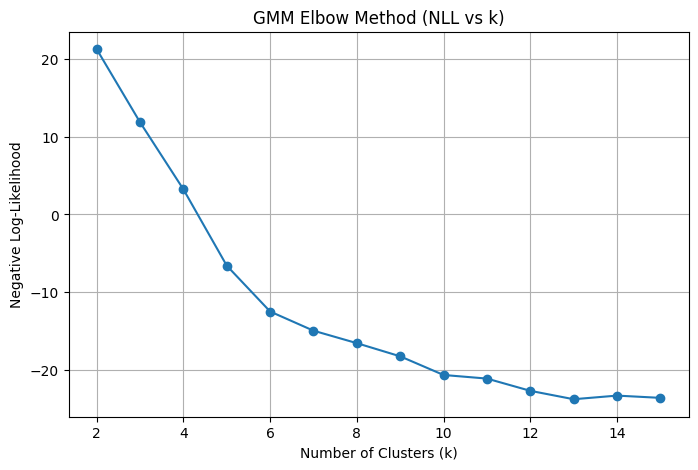

In [47]:
plt.figure(figsize=(8,5))
plt.plot(k_values, nll_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Negative Log-Likelihood")
plt.title("GMM Elbow Method (NLL vs k)")
plt.grid(True)
plt.show()


### 5.3 GMM Clustering
After identifying a suitable cluster range from the elbow analysis, we trained a Gaussian Mixture Model with ten components to generate the actual player role assignments. The model was fitted on the preprocessed feature matrix using full covariance matrices, allowing flexible cluster shapes. We then produced hard assignments, where each player is mapped to the single most likely cluster based on the model’s output. Although the GMM also provides soft probability distributions for each cluster, in this step we only used the hard labels and did not attach probability columns to the dataset. Finally, we inspected the distribution of cluster memberships to understand how players were grouped within the ten-cluster structure.

In [48]:
# Hard assignments (main role)
from sklearn.mixture import GaussianMixture

gmm10= GaussianMixture(
    n_components=10,
    covariance_type="full",
    random_state=42
)

gmm10.fit(X)



GaussianMixture(n_components=10, random_state=42)

In [49]:
# Hard assignments (main role)
labels_10 = gmm10.predict(X)

# Soft assignments (probability of each role)
probs_10= gmm10.predict_proba(X)

# Add to dataframe
player_df["gmm10_cluster"] = labels_10

for k in range(10):
    player_df[f"gmm8_prob_{k}"] = probs_10[:, k]



In [50]:
player_df["gmm10_cluster"].value_counts()

,count
gmm10_cluster,
9,3324
4,2173
1,2052
5,2000
3,1967
7,1917
2,1766
8,1549
6,1509


####5.3.1 Silhouette Evaluation of the GMM Model
To assess the quality of the ten-cluster Gaussian Mixture Model, we calculated the silhouette score using the model’s hard cluster labels. The silhouette metric measures how well each point fits within its assigned cluster compared to neighboring clusters, with values closer to 1 indicating strong separation and values near or below 0 indicating poor structure. The computed silhouette score for the GMM was negative, suggesting that the cluster boundaries were weak and that the data points were not well separated under this configuration. This result indicated that the ten-cluster GMM was not an appropriate model for the dataset and motivated us to explore alternative clustering approaches.

In [51]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X, labels_10)
print("Silhouette Score for GMM(8):", sil_score)


Silhouette Score for GMM(8): -0.04021013325757245


###5.4 Evaluation of Agglomerative Clustering Performance
To assess the quality of the hierarchical clustering models, we calculated silhouette scores for both the eight-cluster and nine-cluster Agglomerative Clustering configurations. The silhouette scores were modest—approximately 0.14 for eight clusters and 0.12 for nine clusters—indicating weak but present separation between clusters. Although the scores were not high, the eight-cluster model performed slightly better. We also examined the cluster membership distribution for the eight-cluster solution, which revealed substantial imbalance: most players were grouped into just a few large clusters, while several smaller clusters contained relatively few observations. This provided insight into the model’s behavior.

In [52]:
from sklearn.cluster import AgglomerativeClustering

agg8 = AgglomerativeClustering(
    n_clusters=8,
    linkage="ward"
)
agg8_labels = agg8.fit_predict(X)
player_df["agg8_cluster"] = agg8_labels


agg9 = AgglomerativeClustering(
    n_clusters=9,
    linkage="ward"
)
agg9_labels = agg9.fit_predict(X)
player_df["agg9_cluster"] = agg9_labels


In [53]:
player_df["agg8_cluster"] =  agg8_labels
player_df["agg9_cluster"]=agg9_labels


In [54]:
from sklearn.metrics import silhouette_score

sil_agg8 = silhouette_score(X, agg8_labels)
print("Silhouette score – Agglomerative (8 clusters):", sil_agg8)

sil_agg9 = silhouette_score(X, agg9_labels)
print("Silhouette score – Agglomerative (9 clusters):", sil_agg9)


Silhouette score – Agglomerative (8 clusters): 0.0908867705339018
Silhouette score – Agglomerative (9 clusters): 0.06296153103325168


In [55]:
player_df["agg8_cluster"].value_counts()

,count
agg8_cluster,
0,5473
1,5321
3,2587
4,2200
5,1732
2,1616
6,675
7,147


####5.5.1 Cluster Profiling for the Agglomerative Model
After generating the eight-cluster Agglomerative Clustering solution, we computed the mean values of all selected features within each cluster to create a detailed cluster profile. This step was performed to help us interpret the clusters by identifying what type of players each group represents. By summarizing physical attributes, cumulative statistics, and per-minute performance metrics, we could evaluate whether a cluster corresponded to high-usage scorers, rebounders, defensive specialists, facilitators, or lower-impact role players. These profiles provided the essential interpretability needed to connect the mathematical clusters to meaningful basketball roles and assess whether the eight-cluster structure produced distinct and sensible player categories.

In [56]:
cluster_profile = player_df.groupby("agg8_cluster")[selected_cols].mean()
cluster_profile


,position,weight,height_inches,gp_sum,minutes_sum,pts_sum,oreb_sum,dreb_sum,reb_sum,asts_sum,...,stl_per_min,blk_per_min,turnover_per_min,pf_per_min,fga_per_min,fgm_per_min,fta_per_min,ftm_per_min,tpa_per_min,tpm_per_min
agg8_cluster,,,,,,,,,,,,,,,,,,,,,
0,1.451672,-0.430578,-0.491642,-0.374036,-0.500107,-0.535936,-0.587191,-0.592470,-0.464990,-0.365780,...,-0.413506,-0.500036,-0.317448,-0.138987,-0.215648,-0.379879,-0.294986,-0.304981,-0.271421,-0.227086
1,0.758692,0.632903,0.663781,-0.407899,-0.696714,-0.593115,-0.043601,-0.145734,-0.375712,-0.585571,...,0.104971,0.432105,0.134986,0.428848,-0.249839,-0.223839,-0.073775,-0.165460,-0.341767,-0.349030
2,1.668936,-0.329671,-0.368713,-0.212021,-0.374388,-0.338255,-0.330575,-0.231898,-0.503805,-0.167021,...,0.310734,-0.238140,0.147240,-0.269030,0.026718,-0.134763,-0.402524,-0.336528,2.072066,1.812479
3,0.680711,0.654993,0.777577,0.665646,0.971100,0.894281,1.672894,1.677695,1.199536,0.215850,...,0.226064,0.927974,0.258299,-0.060427,0.105069,0.342867,0.307966,0.284217,-0.362783,-0.338669
4,1.802273,-0.751735,-0.750697,0.522752,0.808286,0.609997,0.176647,0.245977,-0.051042,1.182041,...,0.665352,-0.264085,0.305053,-0.336208,0.216282,0.342804,-0.023694,0.166363,-0.039722,0.039382
5,1.188799,-0.151251,-0.210915,0.659953,1.139153,1.089548,-0.640834,-0.645500,1.176886,0.686041,...,-0.923335,-0.576264,-0.611976,-0.049869,0.465647,0.537181,0.705812,0.691427,-0.400811,-0.366919
6,1.595556,-0.207028,-0.298578,0.688504,1.210482,1.243594,0.485577,0.829362,0.373807,1.190778,...,0.645896,-0.043027,0.509236,-0.382462,0.583467,0.485961,0.234115,0.306606,2.442010,2.361888
7,1.523810,-0.399752,-0.391335,0.546206,-0.212526,1.726119,0.310656,0.473641,0.521168,1.610576,...,2.156844,0.202406,1.075305,1.047928,3.527124,4.002115,3.621890,3.997443,0.185877,0.012194


###5.6 DBSCAN Density-Based Clustering Exploration
To explore a non-parametric alternative to hierarchical and mixture-model clustering, we applied DBSCAN, which groups players based on density rather than assuming a fixed number of clusters. We initially tested DBSCAN with a moderate neighborhood radius and minimum sample threshold, generating cluster labels where noise points were assigned as -1. To evaluate performance, we computed the silhouette score using only the non-noise points, obtaining a value around 0.16—higher than the agglomerative and GMM scores but still indicating limited structure. Because DBSCAN is highly sensitive to its hyperparameters, we systematically searched across a range of eps and min_samples values. The results showed that DBSCAN consistently produced many noise points and only a small number of meaningful clusters, often collapsing most players into a single dominant cluster. This indicated that while DBSCAN captured some density variations, it did not produce a balanced or interpretable role structure for this dataset.

In [57]:

from sklearn.cluster import DBSCAN
for eps in [0.3, 0.4, 0.5, 0.6, 0.8]:
    for ms in [5, 10, 20]:
        labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(X)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        print(f"eps={eps}, min_samples={ms} → clusters={n_clusters}, noise={n_noise}")


eps=0.3, min_samples=5 → clusters=8, noise=19664
eps=0.3, min_samples=10 → clusters=1, noise=19722
eps=0.3, min_samples=20 → clusters=0, noise=19751
eps=0.4, min_samples=5 → clusters=7, noise=19588
eps=0.4, min_samples=10 → clusters=2, noise=19657
eps=0.4, min_samples=20 → clusters=1, noise=19702
eps=0.5, min_samples=5 → clusters=6, noise=19509
eps=0.5, min_samples=10 → clusters=5, noise=19563
eps=0.5, min_samples=20 → clusters=2, noise=19647
eps=0.6, min_samples=5 → clusters=3, noise=19437
eps=0.6, min_samples=10 → clusters=4, noise=19499
eps=0.6, min_samples=20 → clusters=2, noise=19598
eps=0.8, min_samples=5 → clusters=4, noise=19337
eps=0.8, min_samples=10 → clusters=3, noise=19360
eps=0.8, min_samples=20 → clusters=4, noise=19416


In [58]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(
    eps=0.6,          # distance threshold (tune this)
    min_samples=10,   # minimum cluster size, tune as well
    metric='euclidean'
)

dbscan_labels = dbscan.fit_predict(X)


In [59]:
from sklearn.metrics import silhouette_score

valid_labels = dbscan_labels[dbscan_labels != -1]
valid_points = X[dbscan_labels != -1]

if len(np.unique(valid_labels)) > 1:
    sil_dbscan = silhouette_score(valid_points, valid_labels)
    print("DBSCAN Silhouette Score:", sil_dbscan)
else:
    print("DBSCAN found fewer than 2 clusters — silhouette not valid.")


DBSCAN Silhouette Score: 0.4757195393413714


In [60]:
player_df["dbscan_cluster"] = dbscan_labels


In [61]:
player_df["dbscan_cluster"].value_counts()

,count
dbscan_cluster,
-1,19499
0,113
1,92
3,27
2,20


###5.7 Role Assignment Based on Cluster Profiles
After selecting the eight-cluster Agglomerative model as the most interpretable option, we assigned basketball role labels to each cluster. To do this, we examined the cluster mean profiles generated earlier, comparing differences in scoring volume, creation ability, rebounding, rim protection, defensive indicators, and physical attributes. Using these statistical patterns, we manually mapped each cluster to a descriptive basketball role such as “Playmaking Guard,” “Scoring Wing,” or “Rim Protector Center.” These role definitions were then encoded into a dictionary and applied to the dataset by mapping cluster IDs to their corresponding role labels. This step translated the purely mathematical cluster assignments into meaningful basketball player archetypes that can be understood and used by coaches, analysts, and downstream modeling tasks.

In [62]:
role_labels_agg8 = {
    0: "Pure Scorer",
    1: "Rim Protector",
    2: "Deep Bench",
    3: "Interior Big",
    4: "Playmaker",
    5: "Slashing Short",
    6: "Versatile Wing",
    7: "High Intensity/ Statistical Outliers"
}


In [63]:
player_df.columns

Index(['ilkid', 'year', 'position', 'weight', 'height_inches', 'gp_sum',
       'minutes_sum', 'pts_sum', 'oreb_sum', 'dreb_sum', 'reb_sum', 'asts_sum',
       'stl_sum', 'blk_sum', 'turnover_sum', 'pf_sum', 'fga_sum', 'fgm_sum',
       'fta_sum', 'ftm_sum', 'tpa_sum', 'tpm_sum', 'pts_per_min',
       'oreb_per_min', 'dreb_per_min', 'reb_per_min', 'asts_per_min',
       'stl_per_min', 'blk_per_min', 'turnover_per_min', 'pf_per_min',
       'fga_per_min', 'fgm_per_min', 'fta_per_min', 'ftm_per_min',
       'tpa_per_min', 'tpm_per_min', 'gmm10_cluster', 'gmm8_prob_0',
       'gmm8_prob_1', 'gmm8_prob_2', 'gmm8_prob_3', 'gmm8_prob_4',
       'gmm8_prob_5', 'gmm8_prob_6', 'gmm8_prob_7', 'gmm8_prob_8',
       'gmm8_prob_9', 'agg8_cluster', 'agg9_cluster', 'dbscan_cluster'],
      dtype='object')

In [64]:
player_df["agg8_role"] = player_df["agg8_cluster"].map(role_labels_agg8)


###5.8 Dataset Cleanup and Role-Focused Output
After finalizing the eight-cluster Agglomerative model and assigning interpretable role labels, we performed a cleanup step to prepare the final dataset for downstream analysis. This involved removing all intermediate clustering outputs that were no longer needed, including GMM cluster labels, GMM probability columns, DBSCAN labels, and alternative agglomerative cluster versions. By dropping these temporary columns, we retained only the essential information: the original player statistics, the eight-cluster assignment, and the corresponding role label derived from the cluster profiling. The resulting dataset, saved as player_df_roles, represents a clean, role-enhanced player database suitable for further analysis, visualization, or integration into the broader Court Dynamics modeling pipeline.

In [65]:
player_df.columns

Index(['ilkid', 'year', 'position', 'weight', 'height_inches', 'gp_sum',
       'minutes_sum', 'pts_sum', 'oreb_sum', 'dreb_sum', 'reb_sum', 'asts_sum',
       'stl_sum', 'blk_sum', 'turnover_sum', 'pf_sum', 'fga_sum', 'fgm_sum',
       'fta_sum', 'ftm_sum', 'tpa_sum', 'tpm_sum', 'pts_per_min',
       'oreb_per_min', 'dreb_per_min', 'reb_per_min', 'asts_per_min',
       'stl_per_min', 'blk_per_min', 'turnover_per_min', 'pf_per_min',
       'fga_per_min', 'fgm_per_min', 'fta_per_min', 'ftm_per_min',
       'tpa_per_min', 'tpm_per_min', 'gmm10_cluster', 'gmm8_prob_0',
       'gmm8_prob_1', 'gmm8_prob_2', 'gmm8_prob_3', 'gmm8_prob_4',
       'gmm8_prob_5', 'gmm8_prob_6', 'gmm8_prob_7', 'gmm8_prob_8',
       'gmm8_prob_9', 'agg8_cluster', 'agg9_cluster', 'dbscan_cluster',
       'agg8_role'],
      dtype='object')

In [66]:
drop_col = ['gmm10_cluster',
       'gmm8_prob_0', 'gmm8_prob_1', 'gmm8_prob_2', 'gmm8_prob_3',
       'gmm8_prob_4', 'gmm8_prob_5', 'gmm8_prob_6', 'gmm8_prob_7',
       'gmm8_prob_8', 'gmm8_prob_9', 'agg8_cluster', 'agg9_cluster',
       'dbscan_cluster']
player_df = player_df.drop(columns = drop_col)


In [67]:
player_df_roles = player_df.copy()

###5.9 Verifying Order and Computing Year-to-Year Stat Differences
To study player development over time, we first sorted the player_df_roles dataframe by player identifier (ilkid) and season (year) and reset the index to enforce a consistent chronological order for each player. We then verified that this sorted dataframe matched the ordering of a reference year-by-year dataframe by checking equality of the ilkid and year columns, ensuring that subsequent operations compared the correct seasons for the same player. After this alignment check, we defined a list of both cumulative (e.g., pts_sum, reb_sum, fgm_sum) and per-minute statistics and computed year-to-year differences for each metric using a groupby("ilkid").diff() operation on player_df_model. The resulting _year_diff columns capture how each player’s totals and per-minute performance changed from one season to the next, providing a basis for analyzing progression, regression, and role evolution over time.

In [68]:
player_df_model_pre["agg8_role"] = player_df_roles["agg8_role"].values


In [69]:
player_df_model_pre = player_df_model_pre.sort_values(
    by=["ilkid", "year"],
    ascending=[True, True]
).reset_index(drop=True)


In [70]:
(player_df_model_pre["ilkid"].values == player_df_model_pre["ilkid"].values).all(), \
(player_df_model_pre["year"].values == player_df_model_pre["year"].values).all()


(np.True_, np.True_)

In [71]:
stat_cols = ['gp_sum', 'minutes_sum', 'pts_sum', 'oreb_sum',
       'dreb_sum', 'reb_sum', 'asts_sum', 'stl_sum', 'blk_sum', 'turnover_sum',
       'pf_sum', 'fga_sum', 'fgm_sum', 'fta_sum', 'ftm_sum', 'tpa_sum',
       'tpm_sum', 'pts_per_min', 'oreb_per_min', 'dreb_per_min', 'reb_per_min',
       'asts_per_min', 'stl_per_min', 'blk_per_min', 'turnover_per_min',
       'pf_per_min', 'fga_per_min', 'fgm_per_min', 'fta_per_min',
       'ftm_per_min', 'tpa_per_min', 'tpm_per_min'
]

# Compute differences
for col in stat_cols:
    player_df_model_pre[col + "_year_diff"] = player_df_model_pre.groupby("ilkid")[col].diff()


In [72]:
player_df_model_pre

,ilkid,year,position,weight,height_inches,gp_sum,minutes_sum,pts_sum,oreb_sum,dreb_sum,...,stl_per_min_year_diff,blk_per_min_year_diff,turnover_per_min_year_diff,pf_per_min_year_diff,fga_per_min_year_diff,fgm_per_min_year_diff,fta_per_min_year_diff,ftm_per_min_year_diff,tpa_per_min_year_diff,tpm_per_min_year_diff
0,ABDELAL01,1990,F,240.0,NaN,43.0,290.000000,135.0,27.0,62.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABDELAL01,1991,F,240.0,NaN,71.0,934.000000,432.0,81.0,179.0,...,0.012973,-0.041379,-0.075862,0.006845,0.386510,0.000923,-0.043587,-0.004836,0.000000,0.000000
2,ABDELAL01,1992,F,240.0,NaN,12.0,159.000000,64.0,12.0,25.0,...,-0.026767,0.025157,0.000000,0.009616,-0.034308,-0.027056,-0.108137,-0.081370,0.006289,0.000000
3,ABDELAL01,1992,F,240.0,NaN,75.0,1311.000000,578.0,126.0,211.0,...,0.000000,-0.005325,0.073989,-0.006779,0.008592,0.023358,0.088482,0.000000,-0.005527,0.000000
4,ABDELAL01,1992,F,240.0,NaN,0.0,1152.000000,514.0,114.0,186.0,...,0.016493,-0.000735,-0.073989,-0.144165,-0.360793,-0.186880,-0.001677,0.065972,-0.000763,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19746,ZIDEKGE01,1997,C,250.0,84.0,12.0,64.000000,0.0,0.0,13.0,...,-0.003455,0.028659,0.042636,0.118250,-0.073409,0.080875,0.222363,0.197159,0.029523,0.015625
19747,ZIDEKGE01,1997,C,250.0,84.0,6.0,1157.888586,11.0,0.0,4.0,...,0.000000,-0.031250,-0.061636,-0.151932,0.012091,-0.106784,-0.246545,-0.215295,-0.029523,-0.014761
19748,ZIDEKGE01,1997,C,250.0,84.0,0.0,42.000000,18.0,0.0,9.0,...,0.000000,0.047619,0.070565,0.114729,-0.012091,-0.002591,0.282260,0.234641,-0.001727,-0.000864
19749,ZOETJI01,1982,C,240.0,85.0,7.0,30.000000,2.0,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 6: Translating Data to Insights


###6.1 Role-Based Per-Minute Performance Patterns

Using the agglomerative 8-cluster model, we analyzed the average per-minute statistics of each role to understand the underlying playstyle and contributions associated with each cluster. The per-minute view allows us to compare players independently of playing time, making role distinctions much clearer and more interpretable.

Pure Scorer: This role exhibits high scoring volume (0.47 pts/min) and the highest field goal attempt rate relative to other metrics. However, they display minimal contribution in secondary areas, with notably low assist (0.04) and rebounding numbers, indicating a specialized focus on finishing possessions.

Rim Protector: Defined by elite interior defense, this group records the highest block rates (0.036 per minute) and leads in offensive rebounding (0.076). Their three-point volume is negligible, confirming their role as traditional paint-bound anchors.

Deep Bench / Low Usage: These players have the lowest production across all per-minute indicators (0.27 pts/min), confirming the role as rotational pieces with limited usage. They generate minimal impact in scoring, creation, or defensive events.

Interior Big: Distinct from Rim Protectors due to lower block rates, this group specializes in defensive stability. They show strong defensive rebounding numbers (0.129 per minute) but offer limited playmaking or floor-spacing capabilities.

Playmaker: This cluster displays the highest assist rates (0.134 per minute) alongside elite steal numbers (0.039). Their low three-point attempt rate suggests a playstyle focused on driving to the basket to score or create for others rather than perimeter shooting.

Slasher Short: This group represents the highest offensive ceiling, leading the dataset in points per minute (0.51). Uniquely, they combine this scoring load with elite playmaking (0.125 assists) and the highest volume of three-point attempts (0.135), indicating a complete offensive engine role.

Versatile Wing: The profile shows a clear specialization in perimeter play. They maintain high three-point attempt rates (0.118) similar to superstars but with lower usage. Defensively, they contribute significantly with high steal rates (0.031), fitting the prototype of spacing and perimeter defense.

High Intensity / Statistical Outliers: This cluster exhibits anomalous production rates, including extreme scoring (1.28 pts/min) and assist numbers. These values likely represent players with very low total minutes where small sample sizes have inflated per-minute efficiency metrics.

Summary Insight The per-minute role profiles clearly differentiate clusters by playstyle:

Versatile Superstar → Elite scoring, creation, and shooting volume.

Rim Protector / Rebounding Big → Interior defense and board control.

Slashing Playmaker → High assists and steals with low shooting range.

3-and-D Wing → High three-point volume and perimeter defense.

Pure Scorer → Scoring focus with limited secondary contribution.

These patterns validate the clustering output and provide a quantitative basis for distinguishing between high-usage stars and specialized role players.

In [73]:
dev_profile = player_df_model_pre.groupby("agg8_role")[
    [col for col in player_df_model_pre.columns if col.endswith("_sum")]
].mean()
dev_profile


,gp_sum,minutes_sum,pts_sum,oreb_sum,dreb_sum,reb_sum,asts_sum,stl_sum,blk_sum,turnover_sum,pf_sum,fga_sum,fgm_sum,fta_sum,ftm_sum,tpa_sum,tpm_sum
agg8_role,,,,,,,,,,,,,,,,,
Deep Bench,41.750000,937.945250,329.144802,23.507426,73.034653,98.492574,89.501238,29.742574,7.855198,48.636757,74.166460,294.660272,121.809406,66.403465,52.107673,104.275990,33.956064
High Intensity/ Statistical Outliers,64.380952,1087.255951,1419.326531,66.843537,183.210884,356.401361,333.639456,89.034014,22.000000,120.306122,187.612245,1084.972789,555.884354,375.639456,312.598639,35.659864,8.408163
Interior Big,67.945883,2179.096478,980.038655,158.907228,371.235021,527.095477,142.085427,61.176652,74.638964,125.159258,206.018168,724.420178,361.228836,273.470043,195.487051,11.326247,3.086973
Playmaker,63.680909,2028.908519,829.910000,57.786818,147.659091,212.419091,274.783636,79.899091,16.279091,125.616364,159.041818,743.845455,351.453182,208.348182,175.515000,40.417727,15.912727
Pure Scorer,36.914307,821.975620,224.750959,6.164626,16.727937,108.259273,62.203362,8.084963,1.909191,17.162982,69.661612,222.311529,86.799379,64.620501,47.060113,5.898959,2.398502
Rim Protector,35.903590,640.613971,194.554971,42.901898,86.489945,130.723924,32.016914,16.664161,16.150911,30.504229,76.679947,171.673746,77.569254,55.442586,38.287916,3.526969,0.875023
Slashing Short,67.775982,2334.118456,1083.157621,2.539261,8.446882,521.396074,206.662240,1.350462,1.533487,26.903580,216.497691,918.983256,421.685912,361.085450,261.015589,8.149538,2.187644
Versatile Wing,68.628148,2399.915841,1164.508148,78.665185,238.760000,319.321481,275.983704,89.785185,29.262222,152.823704,170.632593,947.459259,403.856296,270.331852,210.623704,294.324444,99.208889


## Step 7: Player Development Framework

In this step, we will go beyond just clustering, and create an interpretable
framework that captures performance patters, progression trajectories and
anomalies.

We will look at role assignments per season, role transitions matrices,
anomaly flags and more.


### 7.0 Collapse to one row per player per year

In [95]:
agg_dict = {c: "sum" for c in dev_features}

df7_clean = (
    df7
    .groupby(["ilkid", "year", "agg8_role"], as_index=False)
    .agg(agg_dict)
    .sort_values(["ilkid", "year"])
    .reset_index(drop=True)
)

# Sanity check – must be 1
df7_clean.groupby(["ilkid", "year"]).size().max()

3

### 7.1 Choose Performance Indicators

Here we will build a development feature set from the indicators that we have.

In [96]:
df7_clean = player_df_model_pre.copy()


candidates = [
    "minutes_sum", "gp_sum",
    "pts_per_min", "reb_per_min", "asts_per_min", "stl_per_min", "blk_per_min",
    "turnover_per_min", "pf_per_min",
    "fga_per_min", "fgm_per_min", "fta_per_min", "ftm_per_min", "tpa_per_min", "tpm_per_min",
]

dev_features = [c for c in candidates if c in df7_clean.columns]

eff_candidates = ["fg_pct", "ft_pct", "tp_pct", "ts_pct", "efg_pct"]
dev_features += [c for c in eff_candidates if c in df7_clean.columns]

dev_features = list(dict.fromkeys(dev_features))

print("Development features used (count={}):".format(len(dev_features)))
print(dev_features)


Development features used (count=15):
['minutes_sum', 'gp_sum', 'pts_per_min', 'reb_per_min', 'asts_per_min', 'stl_per_min', 'blk_per_min', 'turnover_per_min', 'pf_per_min', 'fga_per_min', 'fgm_per_min', 'fta_per_min', 'ftm_per_min', 'tpa_per_min', 'tpm_per_min']


### 7.2 Performance Patterns

Here we can see what a typical player in each role looks like.


In [97]:
role_profile = df7_clean.groupby("agg8_role")[dev_features].median().sort_index()
display(role_profile)

,minutes_sum,gp_sum,pts_per_min,reb_per_min,asts_per_min,stl_per_min,blk_per_min,turnover_per_min,pf_per_min,fga_per_min,fgm_per_min,fta_per_min,ftm_per_min,tpa_per_min,tpm_per_min
agg8_role,,,,,,,,,,,,,,,
Deep Bench,900.000000,44.0,0.364408,0.106666,0.077878,0.031345,0.005935,0.054418,0.087386,0.332148,0.131758,0.067706,0.052377,0.113444,0.035105
High Intensity/ Statistical Outliers,1157.888586,79.0,1.304098,0.281547,0.272047,0.090682,0.013818,0.130410,0.190001,1.054506,0.499184,0.353229,0.295365,0.002591,0.000000
Interior Big,2239.000000,78.0,0.452367,0.254134,0.061045,0.027226,0.027650,0.064988,0.099791,0.352922,0.174769,0.123221,0.089485,0.000882,0.000000
Playmaker,2028.000000,76.0,0.426073,0.103055,0.131560,0.039823,0.006325,0.070164,0.083813,0.372533,0.172840,0.101605,0.083398,0.008826,0.002062
Pure Scorer,867.000000,36.0,0.300000,0.108557,0.070997,0.000000,0.000000,0.000000,0.100182,0.304988,0.114864,0.080094,0.055944,0.000000,0.000000
Rim Protector,524.000000,34.0,0.318124,0.214286,0.044521,0.024070,0.017857,0.054097,0.131436,0.282413,0.125000,0.090098,0.059211,0.000000,0.000000
Slashing Short,2415.500000,76.0,0.484475,0.212859,0.081608,0.000000,0.000000,0.000000,0.097779,0.418455,0.186017,0.155172,0.114753,0.000000,0.000000
Versatile Wing,2588.000000,79.0,0.482149,0.126886,0.100736,0.037184,0.009500,0.063371,0.073774,0.397059,0.172640,0.109733,0.084004,0.118436,0.041705


### 7.3 Progression: Year to Year Change
Here we can see the players development over time.


In [98]:
for c in dev_features:
    df7_clean[f"delta_{c}"] = df7_clean.groupby("ilkid")[c].diff()

delta_cols = [f"delta_{c}" for c in dev_features]
df7_clean[["ilkid","year","agg8_role"] + delta_cols].head(10)

,ilkid,year,agg8_role,delta_minutes_sum,delta_gp_sum,delta_pts_per_min,delta_reb_per_min,delta_asts_per_min,delta_stl_per_min,delta_blk_per_min,delta_turnover_per_min,delta_pf_per_min,delta_fga_per_min,delta_fgm_per_min,delta_fta_per_min,delta_ftm_per_min,delta_tpa_per_min,delta_tpm_per_min
0,ABDELAL01,1990,Rim Protector,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABDELAL01,1991,Rim Protector,644.0,28.0,-0.002990,-0.306897,-0.041379,0.012973,-0.041379,-0.075862,0.006845,0.386510,0.000923,-0.043587,-0.004836,0.000000,0.0
2,ABDELAL01,1992,Rim Protector,-775.0,-59.0,-0.060011,0.232704,0.062893,-0.026767,0.025157,0.000000,0.009616,-0.034308,-0.027056,-0.108137,-0.081370,0.006289,0.0
3,ABDELAL01,1992,Rim Protector,1152.0,63.0,0.038369,0.024351,-0.042298,0.000000,-0.005325,0.073989,-0.006779,0.008592,0.023358,0.088482,0.000000,-0.005527,0.0
4,ABDELAL01,1992,Rim Protector,-159.0,-75.0,0.005296,0.003361,-0.005838,0.016493,-0.000735,-0.073989,-0.144165,-0.360793,-0.186880,-0.001677,0.065972,-0.000763,0.0
5,ABDELAL01,1993,Rim Protector,-993.0,13.0,-0.043665,0.028892,0.004111,-0.003914,-0.000229,0.106918,0.125786,0.345912,0.000000,0.070427,0.034657,0.000000,0.0
6,ABDELAL01,1994,Rim Protector,347.0,41.0,0.103413,-0.064012,0.006824,-0.012579,0.004847,-0.017985,0.079747,0.110610,0.233202,-0.088063,-0.061103,0.003953,0.0
7,ABDELAL01,1994,Rim Protector,-476.0,-51.0,-0.439262,0.041370,-0.025692,0.000000,-0.023715,-0.088933,-0.138867,-0.089855,-0.199868,-0.069170,-0.039526,-0.003953,0.0
8,ABDELAL01,1994,Rim Protector,446.0,48.0,0.466947,-0.043978,0.027311,0.031513,0.025210,0.000000,0.147619,0.095518,-0.033333,0.073529,0.042017,0.004202,0.0
9,ABDULKA01,1969,Slashing Short,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 7.4 Development Tracking
We create a simple score based on the deltas from the previous part.
If there is a **breakout** there was a big positive change, if there is a
**decline**, there was a big negative change.

In [99]:
delta_mat = df7_clean[delta_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)

delta_scaler = StandardScaler()
delta_z = pd.DataFrame(
    delta_scaler.fit_transform(delta_mat),
    columns=delta_cols,
    index=df7_clean.index
)

# Weighting: positive for production, negative for turnovers/fouls
weights = {col: 1.0 for col in delta_cols}
for col in delta_cols:
    if "turnover" in col: weights[col] = -1.2
    if "pf_" in col:      weights[col] = -0.6

# Build breakout index (higher = improving)
df7_clean["breakout_index"] = 0.0
for col, w in weights.items():
    df7_clean["breakout_index"] += w * delta_z[col]

# Decline index (higher = declining) for easier ranking
df7_clean["decline_index"] = -df7_clean["breakout_index"]

df7_clean[["ilkid","year","agg8_role","breakout_index","decline_index"]].head()

,ilkid,year,agg8_role,breakout_index,decline_index
0,ABDELAL01,1990,Rim Protector,0.221552,-0.221552
1,ABDELAL01,1991,Rim Protector,-0.115665,0.115665
2,ABDELAL01,1992,Rim Protector,-3.087311,3.087311
3,ABDELAL01,1992,Rim Protector,3.152197,-3.152197
4,ABDELAL01,1992,Rim Protector,-1.769150,1.769150


#### 7.4.1 Top breakouts in the league
Here we can see the top breakouts across the entire league.

In [101]:
top_breakouts = df7_clean.dropna(subset=delta_cols).sort_values("breakout_index", ascending=False)
display(top_breakouts[["ilkid","year","agg8_role","breakout_index"] + delta_cols].head(20))

,ilkid,year,agg8_role,breakout_index,delta_minutes_sum,delta_gp_sum,delta_pts_per_min,delta_reb_per_min,delta_asts_per_min,delta_stl_per_min,delta_blk_per_min,delta_turnover_per_min,delta_pf_per_min,delta_fga_per_min,delta_fgm_per_min,delta_fta_per_min,delta_ftm_per_min,delta_tpa_per_min,delta_tpm_per_min
690,BAILEJA01,1982,Interior Big,88.728207,1665.000000,69.0,0.169096,0.152886,-0.002099,0.004490,0.014402,-3.796501,-0.150729,0.080816,-0.180000,0.146589,0.090612,0.000583,0.000000
3916,DAMPILO01,1969,Versatile Wing,50.192700,-2168.111414,4.0,1.840419,0.177831,0.248946,0.000000,0.000000,-0.075466,0.202956,1.609827,0.427314,0.350387,-0.092604,0.473275,0.111169
10240,LEEGE01,1966,High Intensity/ Statistical Outliers,50.051829,-242.000000,-18.0,2.027530,-0.222672,0.000000,0.000000,0.000000,0.000000,-0.089069,0.488259,0.600000,1.189474,1.046154,0.000000,0.000000
16584,STACKJE01,2000,Versatile Wing,45.538651,-1990.111414,-2.0,-0.615947,0.171983,0.238146,0.051054,0.035201,0.182754,0.138183,1.204579,0.471825,0.458761,0.378870,0.408502,0.116998
2856,CARTEVI01,2000,Versatile Wing,43.844146,-1968.111414,-7.0,1.113712,0.207003,0.148312,0.063266,0.041388,0.087286,0.177046,1.430189,0.406015,0.257284,0.192163,0.267370,0.109520
14554,RICHMMI01,1993,Versatile Wing,41.395212,-570.111414,33.0,1.003237,0.157881,0.142426,0.058284,0.009474,0.111315,-0.079282,0.780733,0.333713,0.306483,0.253906,0.269456,0.081905
5263,ERVINJU01,1975,Interior Big,40.203772,-2244.111414,0.0,1.437572,0.530202,0.229518,-0.054674,0.092033,-0.088477,0.190865,1.086735,0.550930,0.393012,0.314873,0.063382,0.020839
110,ADAMSMI01,1990,Versatile Wing,40.064606,-1532.111414,-13.0,1.059196,0.221092,0.414488,0.081974,0.004067,0.154857,0.090467,0.859576,0.335684,-0.116729,0.302337,0.326499,0.085492
14548,RICHAQU01,2004,Versatile Wing,39.885034,-1180.111414,14.0,1.015642,0.236610,0.077003,0.082910,0.015192,0.027783,0.114534,0.445704,0.169723,0.071656,0.052870,0.399106,0.143857
15309,RUSSEWA01,1987,Versatile Wing,38.362332,-510.000000,-48.0,-0.307241,-0.107632,0.747554,-0.039139,-0.009785,-0.117417,-0.121331,0.677104,-0.125245,-0.072407,-0.052838,0.968689,-0.003914


### 7.5 Role Trajectories
We can see which players are stable in their roles, and which are likely to
transition to another role.

In [105]:
df7_clean["role_next"] = df7_clean.groupby("ilkid")["agg8_role"].shift(-1)

transitions = df7_clean.dropna(subset=["agg8_role","role_next"]).copy()

trans_mat = pd.crosstab(transitions["agg8_role"], transitions["role_next"], normalize="index")
display(trans_mat)



role_next,Deep Bench,High Intensity/ Statistical Outliers,Interior Big,Playmaker,Pure Scorer,Rim Protector,Slashing Short,Versatile Wing
agg8_role,,,,,,,,
Deep Bench,0.553641,0.000783,0.014096,0.085356,0.176194,0.068128,0.003132,0.098669
High Intensity/ Statistical Outliers,0.014493,0.159420,0.166667,0.362319,0.065217,0.050725,0.152174,0.028986
Interior Big,0.011249,0.009241,0.619124,0.073925,0.020088,0.243471,0.008839,0.014062
Playmaker,0.062379,0.024178,0.076402,0.506286,0.172147,0.078337,0.018859,0.061412
Pure Scorer,0.058272,0.002280,0.013428,0.074487,0.640233,0.121358,0.083861,0.006081
Rim Protector,0.031526,0.001433,0.120850,0.032481,0.108909,0.696680,0.002150,0.005971
Slashing Short,0.002980,0.014899,0.036949,0.044696,0.239571,0.021454,0.638856,0.000596
Versatile Wing,0.256494,0.000000,0.037338,0.163961,0.040584,0.017857,0.006494,0.477273


This matrix shows how players typically move between roles from one season to the next. Each row represents a player's role in the current season, and each column represents their role in the following season. The values show the percentage of players who end up in each role next year. High values on the diagonal mean that most players stay in the same role, while values off the diagonal show common development paths or declines, such as bench players becoming regular rotation players or scorers turning into playmakers. This allows us to understand which roles are stable, which are risky, and how players usually evolve over time.

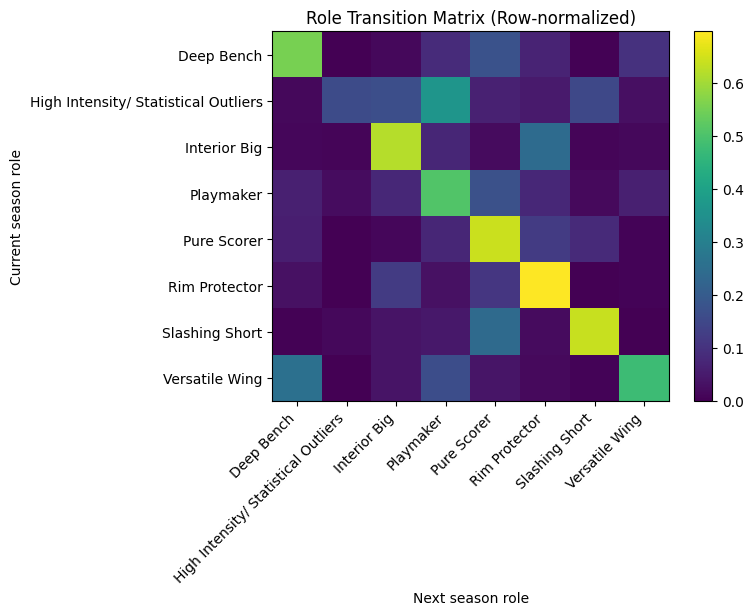

,ilkid,role_changes
2340,PIERCRI01,16
651,DANTLAD01,15
1396,JACKSJI01,15
2633,SCHREDE01,14
328,BREWERO01,14
1457,JOHNSED03,13
1201,HARPERO01,13
1020,GATLICH01,13
1187,HARDAAN01,12
1443,JOHNSAV01,12


In [114]:
plt.figure()
plt.imshow(trans_mat.values, aspect="auto")
plt.xticks(range(trans_mat.shape[1]), trans_mat.columns, rotation=45, ha="right")
plt.yticks(range(trans_mat.shape[0]), trans_mat.index)
plt.title("Role Transition Matrix (Row-normalized)")
plt.xlabel("Next season role")
plt.ylabel("Current season role")
plt.colorbar()
plt.show()

role_changes = (
    df7.sort_values(["ilkid","year"])
       .groupby("ilkid")["agg8_role"]
       .apply(lambda x: (x != x.shift(1)).sum() - 1)
       .rename("role_changes")
       .reset_index()
)

display(role_changes.sort_values("role_changes", ascending=False).head(20))

### 7.6 Anomaly Detection (Year to Year)
Here we will see unusual changes in players year to year transitions.
These are usually caused by injury, role change, a breakout or a significant change in minutes played.

In [106]:
def outlier_score(x):
    x = np.asarray(x, dtype=float)
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    if mad == 0 or np.isnan(mad):
        return np.zeros_like(x)
    return 0.6745 * (x - med) / mad

outlier_cols = []
for col in delta_cols:
    outlier_col = "rz_" + col
    df7_clean[outlier_col] = outlier_score(df7_clean[col].values)
    outlier_cols.append(rz_col)

# Shock score: average absolute robust z across deltas
df7_clean["within_player_shock"] = df7_clean[outlier_cols].abs().mean(axis=1)

display(df7_clean.sort_values("within_player_shock", ascending=False)[
    ["ilkid","year","agg8_role","within_player_shock"] + delta_cols
].head(25))

,ilkid,year,agg8_role,within_player_shock,delta_minutes_sum,delta_gp_sum,delta_pts_per_min,delta_reb_per_min,delta_asts_per_min,delta_stl_per_min,delta_blk_per_min,delta_turnover_per_min,delta_pf_per_min,delta_fga_per_min,delta_fgm_per_min,delta_fta_per_min,delta_ftm_per_min,delta_tpa_per_min,delta_tpm_per_min
19750,ZOPFBI01,1970,Pure Scorer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,ABDELAL01,1990,Rim Protector,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABDELAL01,1991,Rim Protector,0.0,644.000000,28.0,-0.002990,-0.306897,-0.041379,0.012973,-0.041379,-0.075862,0.006845,0.386510,0.000923,-0.043587,-0.004836,0.000000,0.000000
2,ABDELAL01,1992,Rim Protector,0.0,-775.000000,-59.0,-0.060011,0.232704,0.062893,-0.026767,0.025157,0.000000,0.009616,-0.034308,-0.027056,-0.108137,-0.081370,0.006289,0.000000
3,ABDELAL01,1992,Rim Protector,0.0,1152.000000,63.0,0.038369,0.024351,-0.042298,0.000000,-0.005325,0.073989,-0.006779,0.008592,0.023358,0.088482,0.000000,-0.005527,0.000000
4,ABDELAL01,1992,Rim Protector,0.0,-159.000000,-75.0,0.005296,0.003361,-0.005838,0.016493,-0.000735,-0.073989,-0.144165,-0.360793,-0.186880,-0.001677,0.065972,-0.000763,0.000000
5,ABDELAL01,1993,Rim Protector,0.0,-993.000000,13.0,-0.043665,0.028892,0.004111,-0.003914,-0.000229,0.106918,0.125786,0.345912,0.000000,0.070427,0.034657,0.000000,0.000000
19734,ZAWOLRO01,1953,Slashing Short,0.0,1173.000000,30.0,0.029162,-0.050883,0.005314,0.000000,0.000000,0.000000,-0.010878,-0.241158,0.024667,-0.058361,-0.020173,0.000000,0.000000
19733,ZAWOLRO01,1952,Pure Scorer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19732,ZASLOMA01,1955,Pure Scorer,0.0,-704.111414,-61.0,-0.345589,-0.088760,0.000000,0.000000,0.000000,0.000000,-0.054272,-0.370969,-0.119423,-0.158817,-0.132653,0.000000,0.000000


### 7.7 Anomaly Detection: Player compared to Peers
Here we see weird player-seasons compared to other players in the same season.


In [109]:
df7_clean["season_anomaly_score"] = np.nan

for yr, sub in df7_clean.groupby("year"):
    if len(sub) < 40:
        continue

    Xs = sub[dev_features].replace([np.inf, -np.inf], np.nan)
    Xs = Xs.fillna(Xs.median(numeric_only=True))

    iso = IsolationForest(
        n_estimators=400,
        contamination=0.03,   # ~3% anomalies per season; tweak if needed
        random_state=42
    )
    iso.fit(Xs)

    # Higher = more anomalous (invert decision_function)
    score = -iso.decision_function(Xs)
    df7_clean.loc[sub.index, "season_anomaly_score"] = score

display(df7_clean.sort_values("season_anomaly_score", ascending=False)[
    ["ilkid","year","agg8_role","season_anomaly_score"] + dev_features
].head(25))

,ilkid,year,agg8_role,season_anomaly_score,minutes_sum,gp_sum,pts_per_min,reb_per_min,asts_per_min,stl_per_min,blk_per_min,turnover_per_min,pf_per_min,fga_per_min,fgm_per_min,fta_per_min,ftm_per_min,tpa_per_min,tpm_per_min
16396,SMITHTO02,1951,High Intensity/ Statistical Outliers,0.278450,3.000000,0.0,1.333333,0.000000,0.666667,0.000000,0.000000,0.000000,0.666667,2.000000,0.000000,2.000000,1.333333,0.000000,0.000000
775,BARBEJO01,1956,High Intensity/ Statistical Outliers,0.259946,5.000000,5.0,1.400000,1.200000,0.000000,0.000000,0.000000,0.000000,0.000000,1.600000,0.400000,1.200000,0.600000,0.000000,0.000000
2996,CHAMBWI01,1959,High Intensity/ Statistical Outliers,0.246284,1157.888586,72.0,2.337876,1.676327,0.145092,0.000000,0.000000,0.000000,0.129546,1.995874,0.919778,0.855868,0.498321,0.000000,0.000000
15102,ROSEJA01,2002,Versatile Wing,0.219691,1157.888586,82.0,1.568372,0.000000,0.341138,0.062182,0.019864,0.246138,0.234047,1.367144,0.554457,0.403320,0.344593,0.310047,0.114864
10240,LEEGE01,1966,High Intensity/ Statistical Outliers,0.217764,5.000000,1.0,2.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.600000,1.400000,1.200000,0.000000,0.000000
9261,JORDAMI01,1991,High Intensity/ Statistical Outliers,0.213457,1157.888586,0.0,2.076193,0.441321,0.422320,0.157183,0.064773,0.172728,0.000000,1.570099,0.814413,0.509548,0.424048,0.086364,0.023318
12058,MILLERE01,1989,Versatile Wing,0.213425,1157.888586,82.0,1.741100,0.000000,0.000000,0.095001,0.000000,0.191728,0.151137,1.111506,0.570867,0.541503,0.469821,0.312638,0.129546
793,BARKLCH01,1988,High Intensity/ Statistical Outliers,0.212487,1157.888586,79.0,1.759237,0.851550,0.280683,0.108819,0.057864,0.219365,0.226274,1.043278,0.604549,0.690049,0.519912,0.139910,0.000000
133,AGUIRMA01,1982,High Intensity/ Statistical Outliers,0.209048,1157.888586,81.0,1.709145,0.438730,0.286729,0.069091,0.022455,0.225410,0.213319,1.372325,0.662413,0.508685,0.370502,0.065637,0.013818
9262,JORDAMI01,1992,High Intensity/ Statistical Outliers,0.208778,1157.888586,78.0,2.194512,0.450821,0.369638,0.190865,0.052682,0.178774,0.162364,1.729873,0.856732,0.491412,0.411093,0.198637,0.069955


### 7.8 Role-based Curves over Time (Patterns)
Here we can see how each role's metrics change over season.

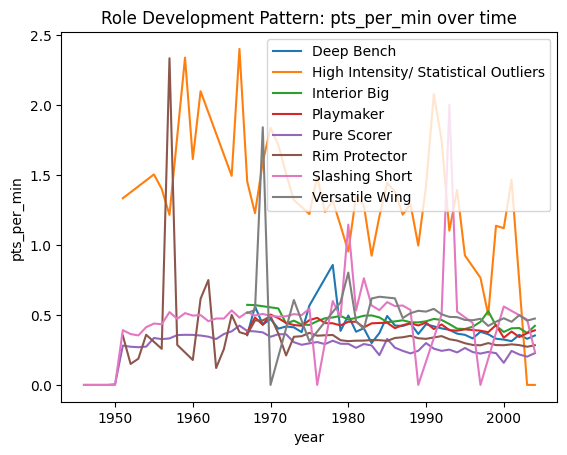

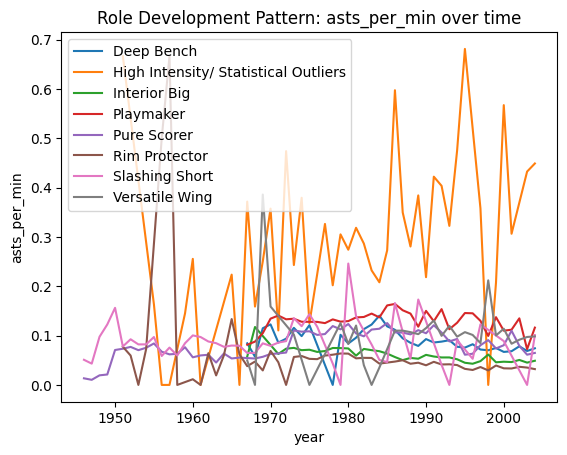

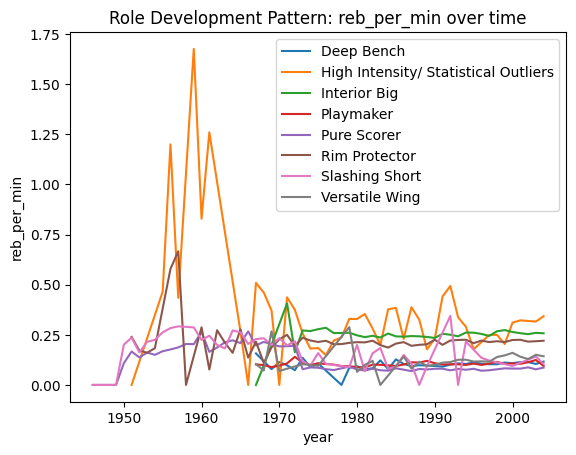

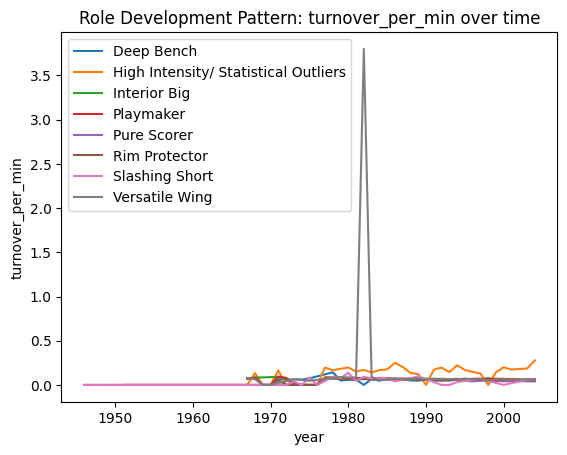

In [111]:
role_year_med = df7_clean.groupby(["agg8_role","year"])[dev_features].median().reset_index()

# Plot a few key indicators if present
to_plot = [c for c in ["pts_per_min","asts_per_min","reb_per_min","turnover_per_min"] if c in dev_features]
if len(to_plot) == 0:
    to_plot = dev_features[:3]  # fallback

for feat in to_plot:
    plt.figure()
    for role in sorted(df7_clean["agg8_role"].unique()):
        sub = role_year_med[role_year_med["agg8_role"] == role]
        plt.plot(sub["year"], sub[feat], label=str(role))
    plt.title(f"Role Development Pattern: {feat} over time")
    plt.xlabel("year")
    plt.ylabel(feat)
    plt.legend()
    plt.show()

### 7.8 Final Scout/Coach report Table
To be described in README.

In [115]:
# Latest season per player
latest = (
    df7_clean.sort_values(["ilkid","year"])
       .groupby("ilkid")
       .tail(1)
       [["ilkid","year","agg8_role","breakout_index","decline_index",
         "within_player_shock","season_anomaly_score"]]
)

report = latest.merge(role_changes, on="ilkid", how="left")

# A simple flag system
report["flag_breakout"] = report["breakout_index"] > report["breakout_index"].quantile(0.95)
report["flag_decline"]  = report["decline_index"]  > report["decline_index"].quantile(0.95)
report["flag_shock"]    = report["within_player_shock"] > report["within_player_shock"].quantile(0.97)
report["flag_anomaly"]  = report["season_anomaly_score"] > report["season_anomaly_score"].quantile(0.97)

# Sort: most interesting first
report = report.sort_values(
    ["flag_breakout","flag_shock","season_anomaly_score","breakout_index"],
    ascending=[False, False, False, False]
)

display(report.head(40))


,ilkid,year,agg8_role,breakout_index,decline_index,within_player_shock,season_anomaly_score,role_changes,flag_breakout,flag_decline,flag_shock,flag_anomaly
2848,STOUDAM01,2004,Interior Big,33.546583,-33.546583,0.0,0.189800,0,True,False,False,True
3063,WADEDW01,2004,High Intensity/ Statistical Outliers,27.601446,-27.601446,0.0,0.187200,1,True,False,False,True
2199,OGGAL01,1992,Rim Protector,29.856864,-29.856864,0.0,0.139448,0,True,False,False,True
2584,RUSSEWA01,1987,Versatile Wing,38.362332,-38.362332,0.0,0.123459,1,True,False,False,True
603,CRAWFJA01,2004,Versatile Wing,25.740061,-25.740061,0.0,0.113371,3,True,False,False,True
2468,RICHAQU01,2004,Versatile Wing,39.885034,-39.885034,0.0,0.111179,3,True,False,False,True
1300,HINRIKI01,2004,Versatile Wing,21.174906,-21.174906,0.0,0.111170,0,True,False,False,True
1432,JEFFECH01,2003,Deep Bench,15.220233,-15.220233,0.0,0.108350,1,True,False,False,True
766,DOUGLJO01,1982,Deep Bench,11.147165,-11.147165,0.0,0.099392,1,True,False,False,True
3331,YARDLGE01,1959,Slashing Short,14.340820,-14.340820,0.0,0.097774,1,True,False,False,True
